In [1]:
# Parameters
system_name = "J1442+4055"
filter = "F160W"
use_psf_variance_map = True
r1 = 3.0
dx_outer = -0.3
dy_outer = 1.0
dx_center = 0.0
dy_center = 0.1
x1 = 38
y1 = 46
x2 = 55
y2 = 42
x3 = 64
y3 = 39
use_center_mask = False
r1_f814w = 2.5
dx_outer_f814w = -0.2
dy_outer_f814w = 0.6
lens_center_x_f814w = 103
lens_center_y_f814w = 80
r1_f475x = 2.5
dx_outer_f475x = -0.2
dy_outer_f475x = 0.6
lens_center_x_f475x = 104
lens_center_y_f475x = 82


In [2]:
# Standard Python imports
import os
import copy
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Astropy imports
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, LogStretch
import astropy.io.fits as pyfits

# Lenstronomy imports
import lenstronomy
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Data.psf import PSF
from lenstronomy.Util import kernel_util
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util, util

## Redirect MCMC output to .txt file to not clutter the notebook later on

In [3]:
import sys
import os
import contextlib

@contextlib.contextmanager
def suppress_stdout_stderr(to_file):
    """
    Redirect stdout and stderr to a file.
    """
    with open(to_file, 'w') as f:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = f
        sys.stderr = f
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Create Masking Function

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def create_central_mask(kwargs_data, x_coords, y_coords,
                        lens_center_x, lens_center_y,
                        r_outer=4.0,
                        dx_outer=0.0, dy_outer=0.0,
                        use_center_mask=False,
                        dx_center=0.2, dy_center=0.1,
                        a_center=0.6, b_center=0.6, phi_center=0.0,
                        plot=True):
    """
    Create a central mask before modeling.

    Parameters
    ----------
    kwargs_data : dict
        Dictionary containing "image_data".
    x_coords, y_coords : array
        Coordinate grids (pixel coordinates).
    lens_center_x, lens_center_y : float
        Lens center coordinates (RA/DEC in arcseconds).
    r_outer : float
        Radius of the outer circular mask (arcsec).
    dx_outer, dy_outer : float
        Offsets for the outer mask.
    use_center_mask : bool
        Whether to apply an additional central ellipse mask.
    dx_center, dy_center : float
        Offsets for the central ellipse mask.
    a_center, b_center : float
        Semi-major and semi-minor axes of the central mask.
    phi_center : float
        Rotation angle (radians).
    plot : bool
        Whether to plot the results.

    Returns
    -------
    mask_img : 2D array
        Final mask array (1 = keep, 0 = masked).
    image_masked : 2D array
        Log-scaled image after masking.
    """

    num_pix = len(kwargs_data["image_data"])

    # Outer circular mask
    mask_outer = mask_util.mask_center_2d(
        lens_center_x + dx_outer,
        lens_center_y + dy_outer,
        r_outer,
        util.image2array(x_coords),
        util.image2array(y_coords),
    )
    mask = 1 - mask_outer

    # Optional central elliptical mask
    if use_center_mask:
        mask_center = mask_util.mask_ellipse(
            util.image2array(x_coords),
            util.image2array(y_coords),
            lens_center_x + dx_center,
            lens_center_y + dy_center,
            a_center,
            b_center,
            phi_center,
        )
        mask *= (1 - mask_center)

    # Ensure binary mask
    mask[mask >= 1] = 1
    mask[mask < 0] = 0

    # Reshape to image grid
    mask_img = mask.reshape(num_pix, num_pix)

    # Apply to image
    image_masked = np.log10(kwargs_data["image_data"] * mask_img)

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(15, 10))
        axs[0].imshow(mask_img, origin="lower")
        axs[0].set_title("MASKING")

        axs[1].imshow(image_masked, origin="lower", cmap="cubehelix")
        axs[1].set_title("IMAGE AFTER MASKING")
        plt.show()

    return mask_img, image_masked

# Prepare F814W Data

/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(
/tmp/ipykernel_1012239/402528142.py:22: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


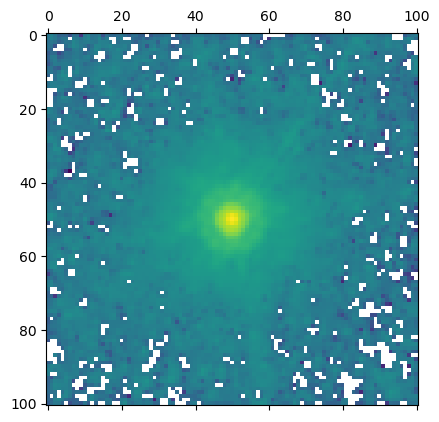

In [5]:
# load F814W PSF data
psf_file = f'cutout_data/{system_name}/F814W/outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf1 = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3, 
              }

if use_psf_variance_map == True:
    variance = np.loadtxt(f'cutout_data/{system_name}/F814W/psf_variance.txt')
    var_array = np.array(variance)
    kwargs_psf1.update({'psf_variance_map': var_array})
    
psf_class = PSF(**kwargs_psf1)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

In [6]:
# Open the FITS file and extract the header
filename = f'joint_modeling/{system_name}/{system_name}_F814W_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

deltaPix = 0.04  # size of UVIS pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates

# set up data class
kwargs_data1 = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

kwargs_numerics1 = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}

/tmp/ipykernel_1012239/2316528304.py:4: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')


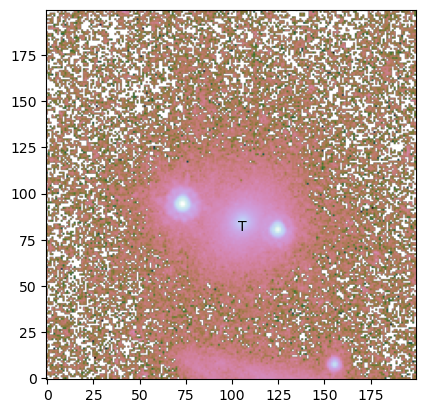

In [7]:
# display science image and obtain coordinates of lens center
plt.annotate('T', [lens_center_x_f814w, lens_center_y_f814w], color='black')

plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')


lens_pos = pixel_grid.map_pix2coord(lens_center_x_f814w, lens_center_y_f814w)

# lens coordinates
lens_center_x, lens_center_y = lens_pos[0], lens_pos[1]

plt.show()

/tmp/ipykernel_1012239/4202579364.py:79: RuntimeWarning: divide by zero encountered in log10
  image_masked = np.log10(kwargs_data["image_data"] * mask_img)
/tmp/ipykernel_1012239/4202579364.py:79: RuntimeWarning: invalid value encountered in log10
  image_masked = np.log10(kwargs_data["image_data"] * mask_img)


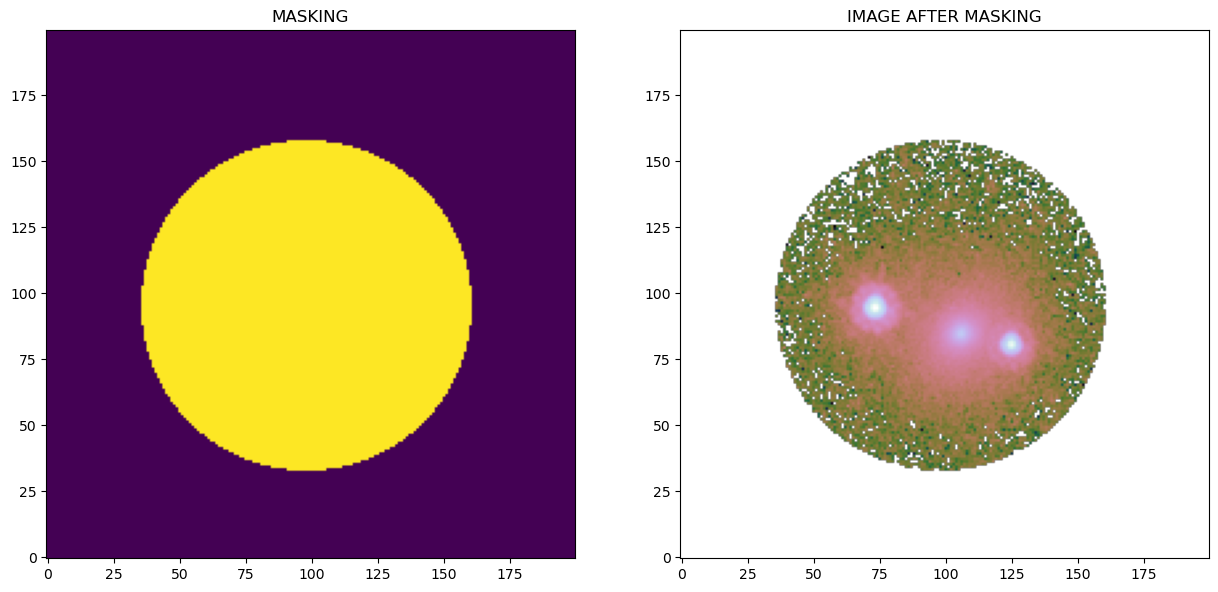

In [8]:
mask_data1, _ = create_central_mask(kwargs_data1, x_coords, y_coords, lens_center_x, lens_center_y,
                                   r1_f814w, dx_outer_f814w, dy_outer_f814w)

# Prepare F475X Data

/tmp/ipykernel_1012239/477278475.py:20: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


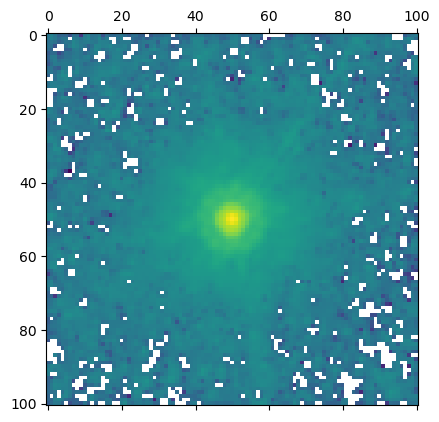

In [9]:
# load F475X PSF data
psf_file = f'cutout_data/{system_name}/F475X/outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf2 = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3, 
              }

if use_psf_variance_map == True:
    variance = np.loadtxt(f'cutout_data/{system_name}/F475X/psf_variance.txt')
    var_array = np.array(variance)
    kwargs_psf2.update({'psf_variance_map': var_array})
    
kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

In [10]:
# Open the FITS file and extract the header
filename = f'joint_modeling/{system_name}/{system_name}_F475X_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

# import the PixelGrid() class #

deltaPix = 0.04  # size of UVIS pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates

# set up data class
kwargs_data2 = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

kwargs_numerics2 = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}

/tmp/ipykernel_1012239/259183908.py:4: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')


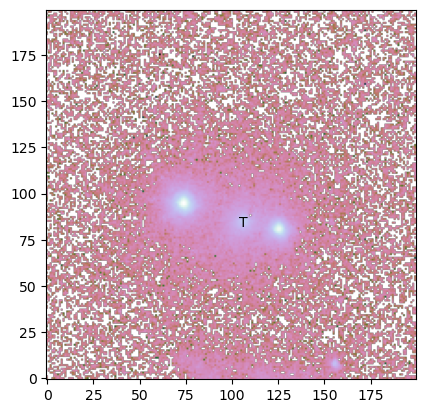

In [11]:
# display science image and obtain coordinates of lens center
plt.annotate('T', [lens_center_x_f475x, lens_center_y_f475x], color='black')

plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')

lens_pos = pixel_grid.map_pix2coord(lens_center_x_f475x, lens_center_y_f475x)

# lens coordinates
lens_center_x, lens_center_y = lens_pos[0], lens_pos[1]

plt.show()

/tmp/ipykernel_1012239/4202579364.py:79: RuntimeWarning: divide by zero encountered in log10
  image_masked = np.log10(kwargs_data["image_data"] * mask_img)
/tmp/ipykernel_1012239/4202579364.py:79: RuntimeWarning: invalid value encountered in log10
  image_masked = np.log10(kwargs_data["image_data"] * mask_img)


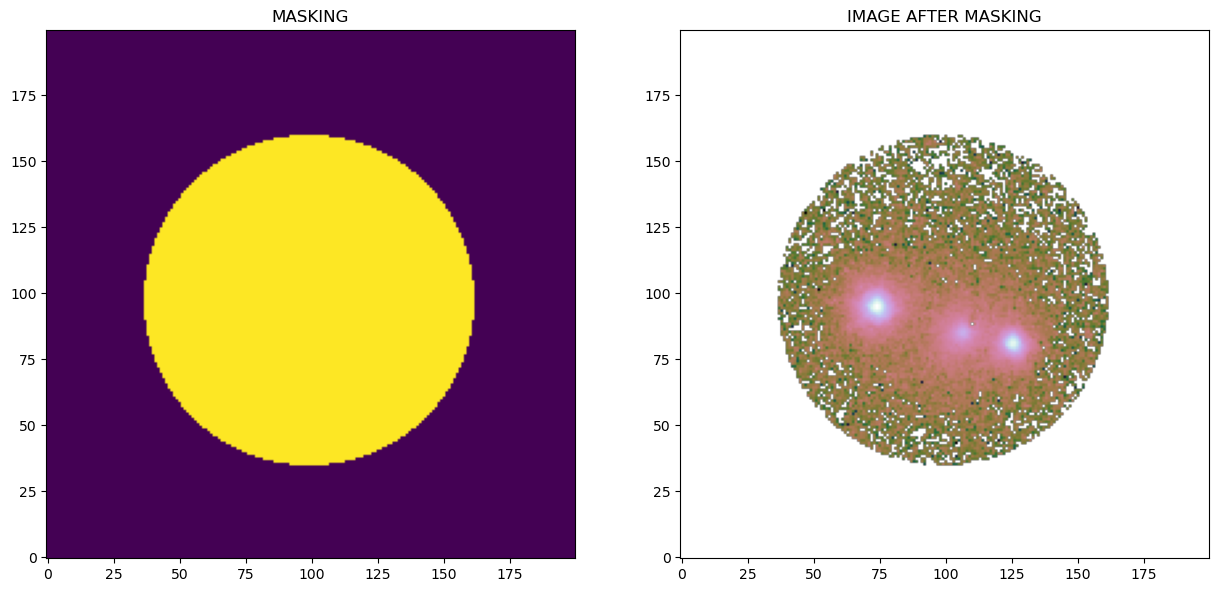

In [12]:
mask_data2, _ = create_central_mask(kwargs_data2, x_coords, y_coords, lens_center_x, lens_center_y,
                                   r1_f475x, dx_outer_f475x, dy_outer_f475x)

# Prepare F160W Data

/tmp/ipykernel_1012239/327559786.py:22: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


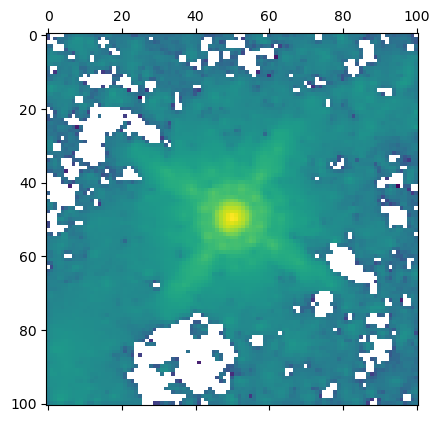

In [13]:
# load F475X PSF data
psf_file = f'cutout_data/{system_name}/F160W/outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf3 = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3, 
              }

if use_psf_variance_map == True:
    variance = np.loadtxt(f'cutout_data/{system_name}/F160W/psf_variance.txt')
    var_array = np.array(variance)
    kwargs_psf3.update({'psf_variance_map': var_array})
    
psf_class = PSF(**kwargs_psf3)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

Initial guess for theta_E: 1.077032961426901


/tmp/ipykernel_1012239/373875719.py:63: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')


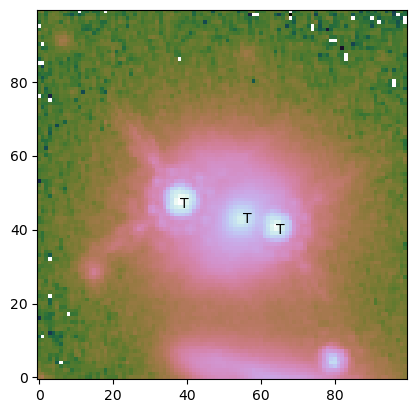

In [14]:
# Open the FITS file and extract the header
filename = f'cutout_data/{system_name}/F160W/{system_name}_F160W_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

# import the PixelGrid() class #

deltaPix = 0.08  # size of IR pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates

# set up data class
kwargs_data3 = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

kwargs_numerics3 = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}

# display science image and obtain coordinates of point source and lens centers
plt.annotate('T', [x1,y1], color='black')
plt.annotate('T', [x2,y2], color='black')
plt.annotate('T', [x3,y3], color='black')

plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')

im1 = pixel_grid.map_pix2coord(x1, y1)

lens_pos = pixel_grid.map_pix2coord(x2,y2)

im2 = pixel_grid.map_pix2coord(x3,y3)

# lens coordinates
lens_center_x, lens_center_y = lens_pos[0], lens_pos[1]
# image coordinates #
im1_x, im1_y = im1[0], im1[1]
im2_x, im2_y = im2[0], im2[1]

# calculate the initial guess for theta_E as half the image separation
einstein_rad = np.sqrt((im2_x - im1_x)**2 + (im2_y - im1_y)**2) / 2
print(f'Initial guess for theta_E: {einstein_rad}')

# set up point source and lens positions
theta_ra = np.array([im1_x, im2_x])
theta_dec = np.array([im1_y, im2_y])

plt.show()

/tmp/ipykernel_1012239/4202579364.py:79: RuntimeWarning: divide by zero encountered in log10
  image_masked = np.log10(kwargs_data["image_data"] * mask_img)
/tmp/ipykernel_1012239/4202579364.py:79: RuntimeWarning: invalid value encountered in log10
  image_masked = np.log10(kwargs_data["image_data"] * mask_img)


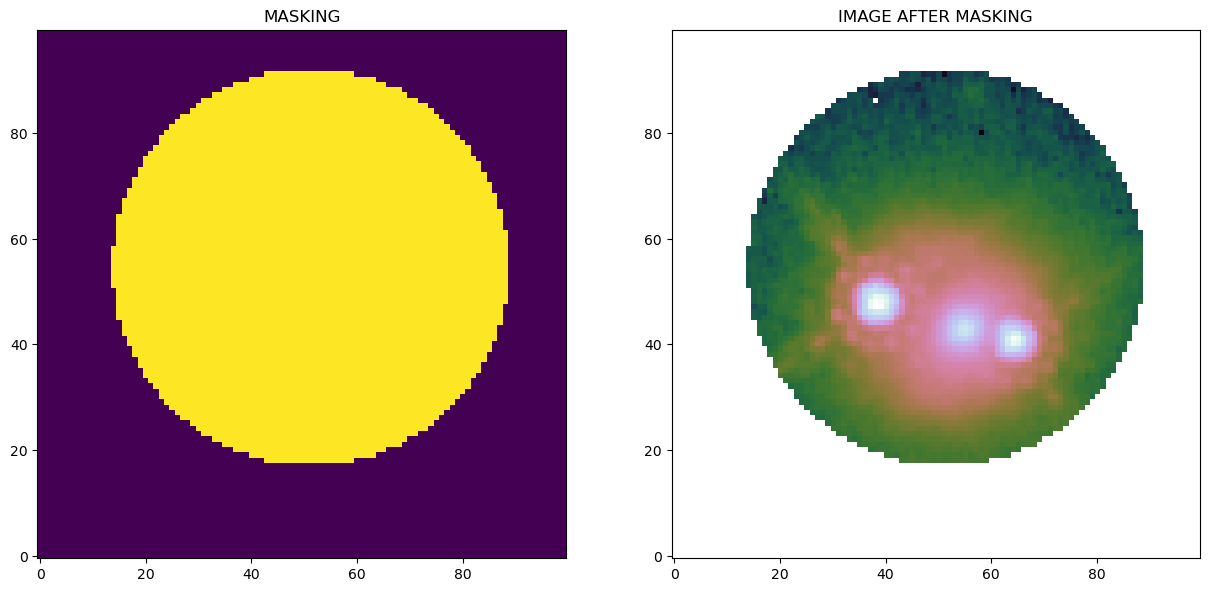

In [15]:
mask_data3, _ = create_central_mask(kwargs_data3, x_coords, y_coords, lens_center_x, lens_center_y,
                                   r1, dx_outer, dy_outer)

In [16]:
# model parameters, applicaple for both bands

lens_model_list = ['EPL', 'SHEAR']

lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']

source_model_list = ['SERSIC_ELLIPSE']

point_source_list = ['LENSED_POSITION']

# set up model arguments

kwargs_model = {'lens_model_list': lens_model_list,
                               'lens_light_model_list': lens_light_model_list,
                               'point_source_model_list': point_source_list,
                               #'source_light_model_list': source_model_list
                               }


kwargs_constraints = {'num_point_source_list': [2],
                              'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]],
                              'joint_lens_light_with_lens_light': [[0, 1, ['center_x', 'center_y']]],
                              #'joint_source_with_point_source': [[0, 0]],
                              }

kwargs_likelihood = {'check_bounds': True,
                     'image_likelihood_mask_list': [mask_data3, mask_data1, mask_data2],
                            #'image_position_uncertainty': 0.004,
                      'source_position_likelihood': True,                              
                      'source_position_tolerance': 0.001
                              }

image_band1 = [kwargs_data1, kwargs_psf1, kwargs_numerics1]
image_band2 = [kwargs_data2, kwargs_psf2, kwargs_numerics2]
image_band3 = [kwargs_data3, kwargs_psf3, kwargs_numerics3]
multi_band_list = [image_band3, image_band1, image_band2]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [17]:
# initial guess of non-linear parameters
kwargs_lens_init = [{'theta_E': einstein_rad, 'gamma': 2., 'e1': 0., 'e2': 0., 'center_x': lens_center_x, 'center_y': lens_center_y},
                    {'gamma1': 0., 'gamma2': 0., 'ra_0': 0, 'dec_0': 0}]
kwargs_lens_light_init = [{'R_sersic': 1., 'n_sersic': 2., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y},
                          {'R_sersic': 2., 'n_sersic': 4., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y}]

kwargs_source_init = [{'R_sersic': 0.3, 'n_sersic': 1., 'e1': 0., 'e2': 0., 'center_x': lens_center_x, 'center_y': lens_center_y}]
kwargs_ps_init = [{'ra_image': theta_ra, 'dec_image': theta_dec}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.2, 'gamma': .5, 'e1': .5, 'e2': .5, 'center_x': 0.1, 'center_y': 0.1},
                     {'gamma1': .1, 'gamma2': .1}]
kwargs_lens_light_sigma = [{'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1},
                           {'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1}]
kwargs_source_sigma = [{'R_sersic': .5, 'n_sersic': .5, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': .1}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 2, 'dec_image': [0.02] * 2}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0.01, 'gamma': 1., 'e1': -0.15, 'e2': -0.15, 'center_x': -10., 'center_y': -10},
                     {'gamma1': -0.3, 'gamma2': -0.3}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.15, 'e2': - 0.15, 'center_x': -10, 'center_y': -10},
                           {'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.15, 'e2': - 0.15, 'center_x': -10, 'center_y': -10}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.15, 'e2': -0.15, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(theta_ra), 'dec_image': -10 * np.ones_like(theta_dec)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'gamma': 3., 'e1': 0.15, 'e2': 0.15, 'center_x': 10., 'center_y': 10},
                     {'gamma1': 0.3, 'gamma2': 0.3}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 6., 'e1': 0.15, 'e2': 0.15, 'center_x': 10, 'center_y': 10},
                           {'R_sersic': 10, 'n_sersic': 6., 'e1': 0.15, 'e2': 0.15, 'center_x': 10, 'center_y': 10}]
kwargs_upper_source = [{'R_sersic': .5, 'n_sersic': 1.5, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(theta_ra), 'dec_image': 10 * np.ones_like(theta_dec)}]


lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}, {}], kwargs_lower_lens_light, kwargs_upper_lens_light]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                 #'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/LensModel/Profiles/epl.py:297: RuntimeWarning: invalid value encountered in divide
  R_omega = Z * hyp2f1(1, t / 2, 2 - t / 2, -(1 - q) / (1 + q) * (Z / Z.conj()))


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [01:28<?, ?it/s]


/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)


-3.3757417801406495 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  3.375741780140641


/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:224: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),


/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:1218: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


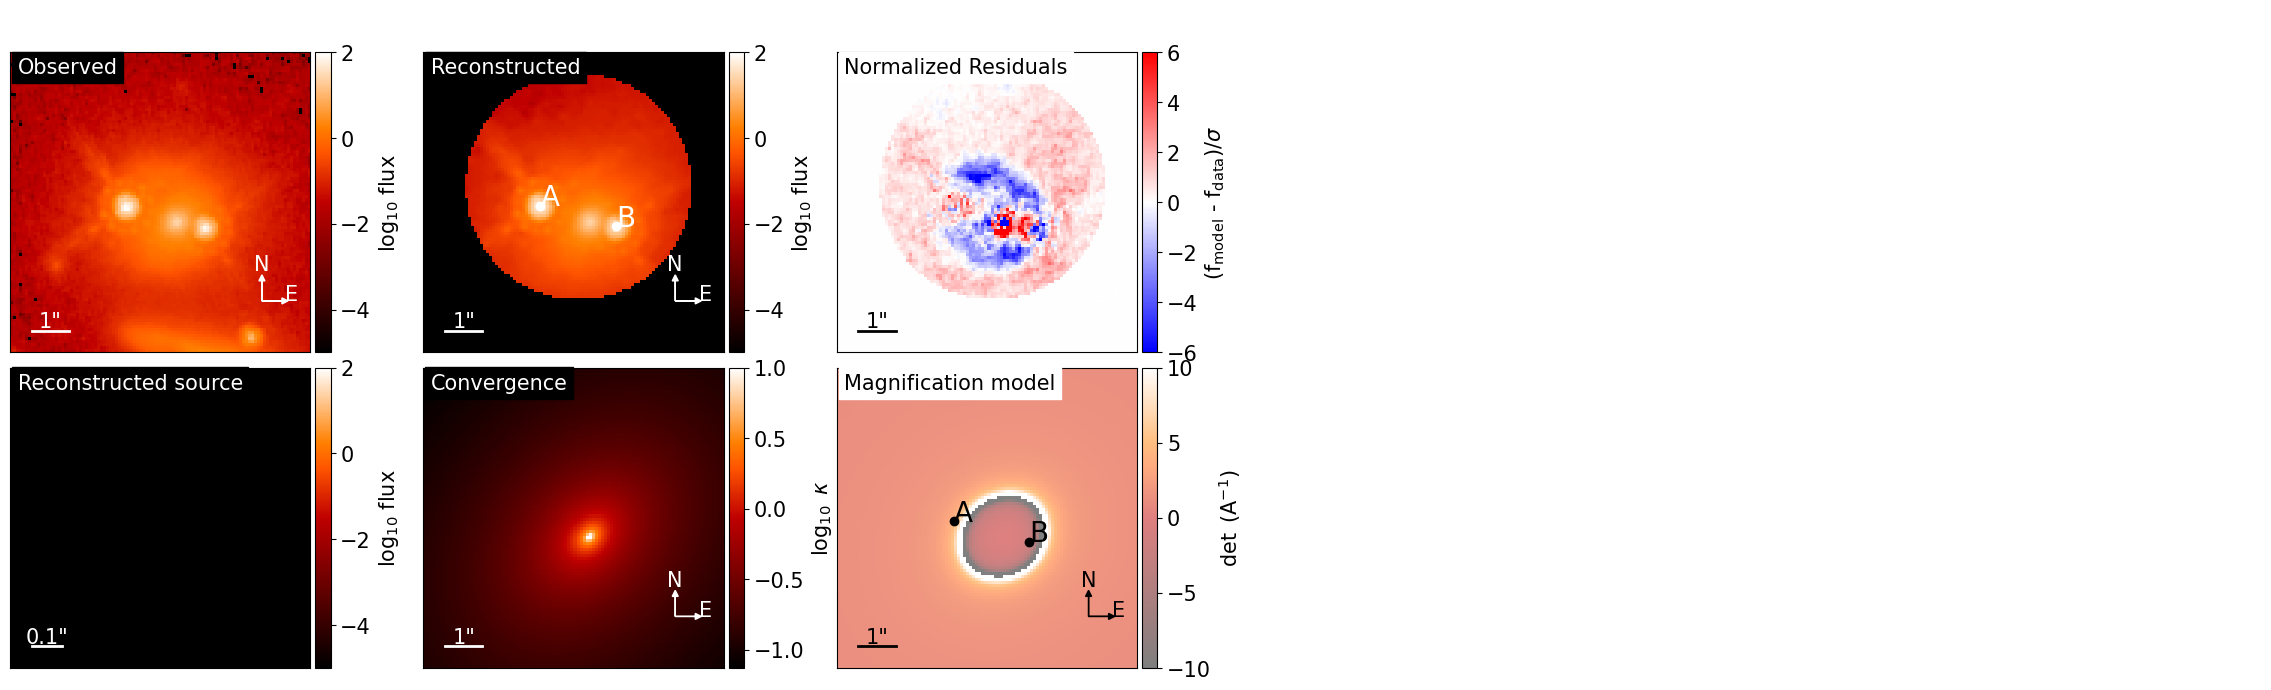

In [18]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, verbose = False)

fitting_kwargs_list = [
    ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, False, False]}}], 
    ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],  # run PSO first band
    ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

filter_index = 0
single_band = [multi_band_list[filter_index]]

# Create ModelPlot with single-band list
modelPlot = ModelPlot(single_band, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")

# Plot
f, axes = modelPlot.plot_main()
f

In [19]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
kwargs_psf_iter = {'stacking_method': 'median', 
                    'psf_symmetry': 4, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 500, 
                    'psf_iter_factor': 0.2,
                    'compute_bands': [True, False, False]
                      }

if use_psf_variance_map ==  True:
    kwargs_psf_iter.update({'keep_psf_variance_map': True})

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

new_multiband = fitting_seq.multi_band_list
kwargs_result = fitting_seq.best_fit()
kwargs_psf_updated = multi_band_list[0][1]

iteration of step 0 gave best reconstruction.
log likelihood before: -7436.759141649851 and log likelihood after: -7436.759141649851


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [01:46<?, ?it/s]

-918.580484267622 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  2.231890338457374
reduced chi^2 of data  1 =  1814.4302208265642
reduced chi^2 of data  2 =  351.48507592721984


/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)


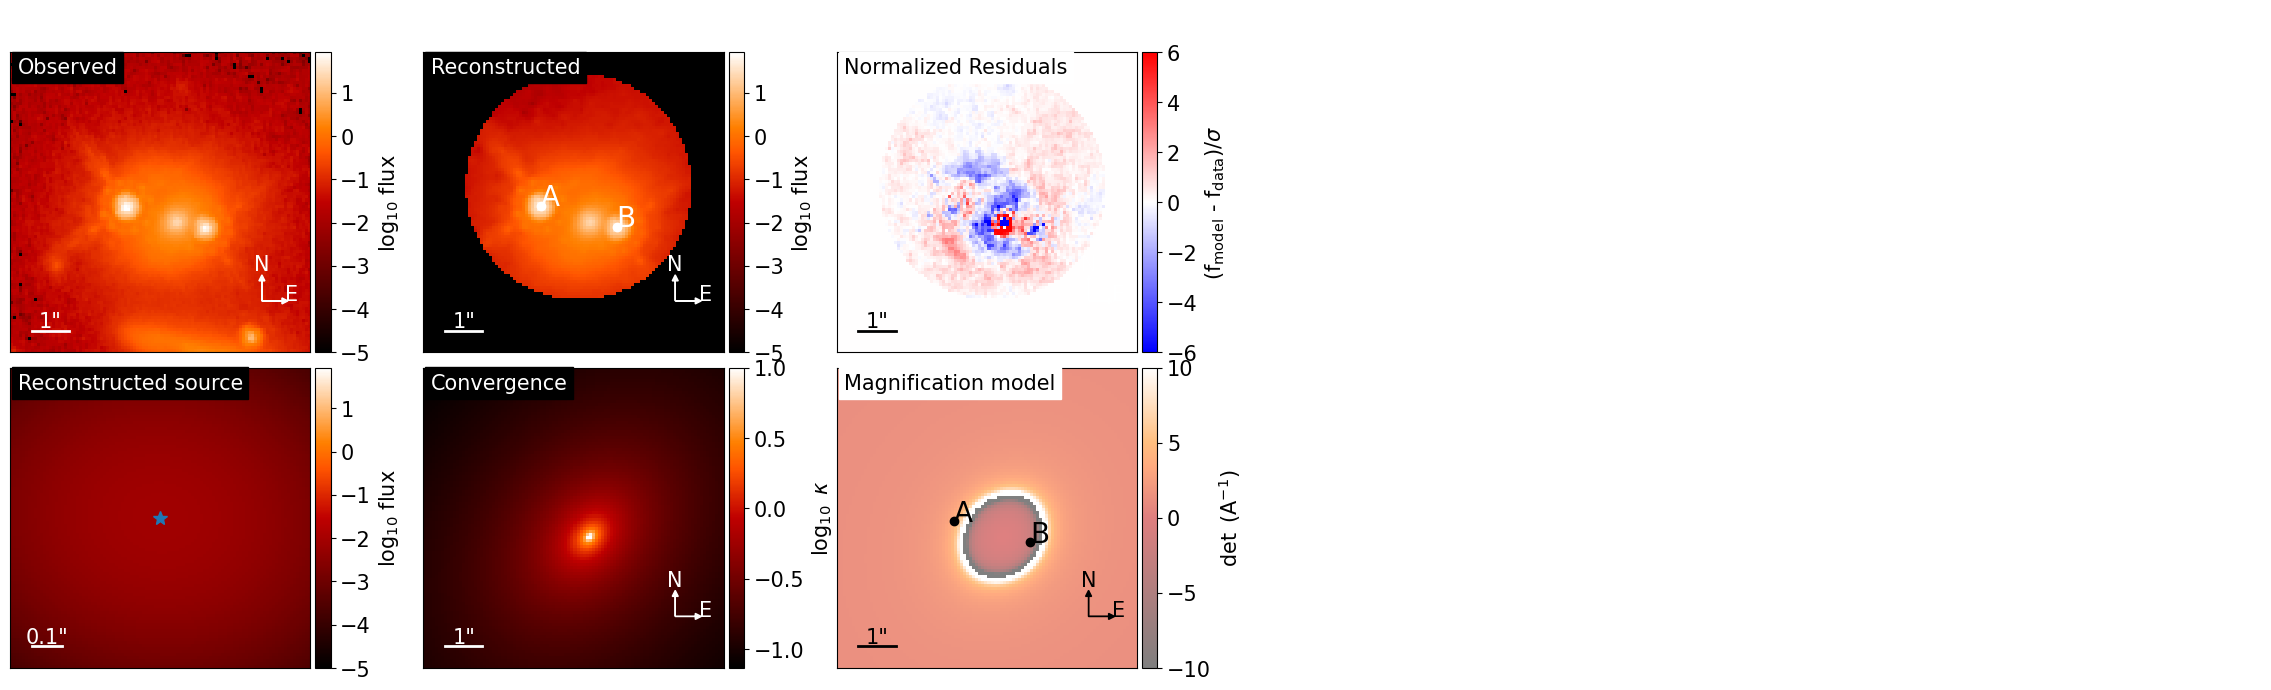

/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:1111: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


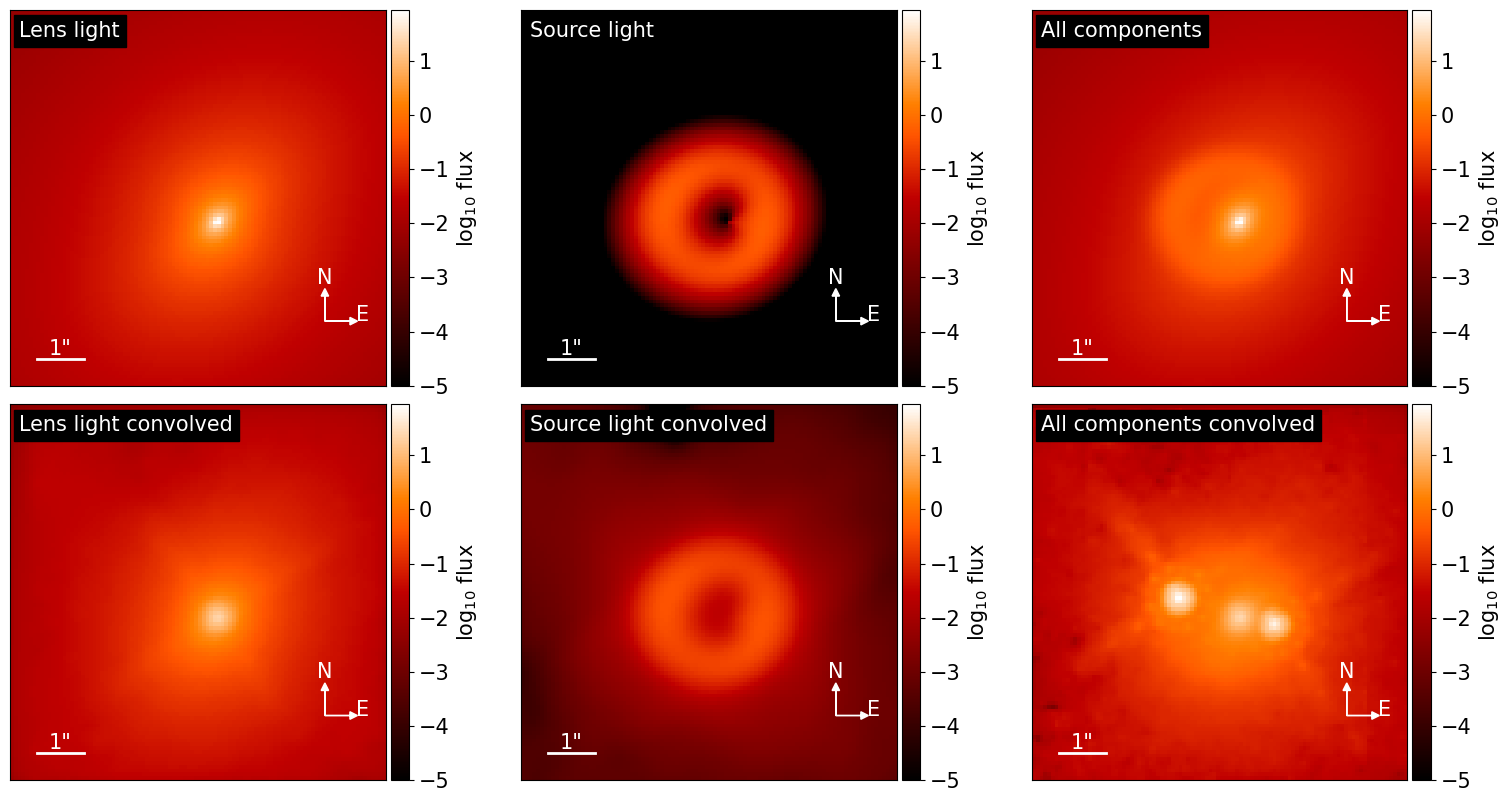

/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:1168: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data - model),


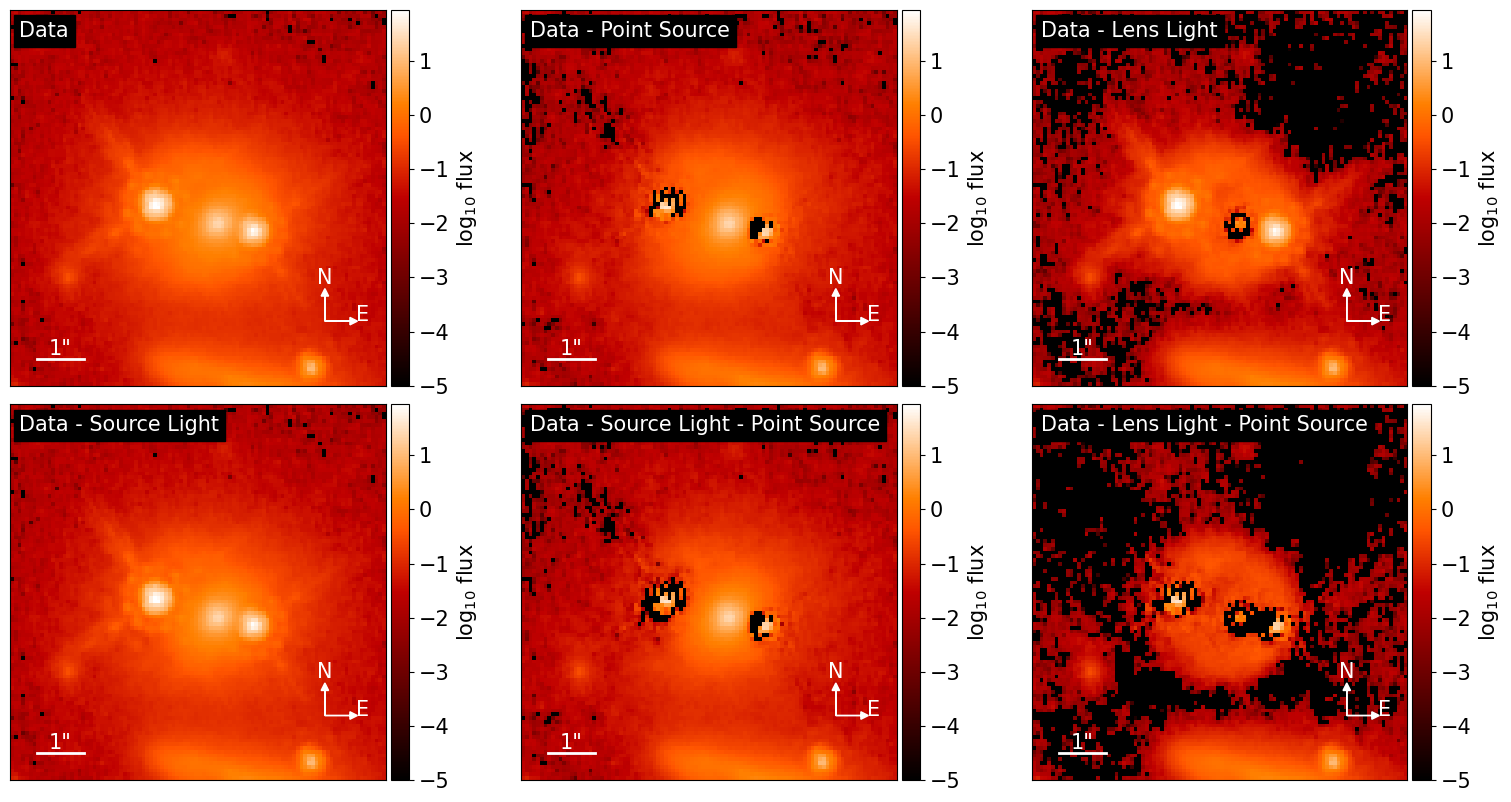

In [20]:
# add source light model arguments and update
# initial guesses to be results of previous run
kwargs_model.update({'source_light_model_list': source_model_list})

kwargs_constraints.update({'joint_source_with_point_source': [[0, 0]]})

lens_params = [kwargs_result['kwargs_lens'], kwargs_lens_sigma, [{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
lens_light_params = [kwargs_result['kwargs_lens_light'], kwargs_lens_light_sigma, [{}, {}], kwargs_lower_lens_light, kwargs_upper_lens_light]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
ps_params = [kwargs_result['kwargs_ps'], kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, verbose = False)

# try to fit the IR reference band as best we can before aligning images

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
multi_band_list = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
display(f)
f, axes = modelPlot.plot_separate()
display(f)
f, axes = modelPlot.plot_subtract_from_data_all()
display(f)


In [21]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

new_multiband = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]

iteration of step 0 gave best reconstruction.
log likelihood before: -4916.854415621529 and log likelihood after: -4916.854415621529


In [22]:
def align_images():
    
    fitting_kwargs_list = [
        ['align_images', {'n_particles': 100, 'n_iterations': 100, 
                      'align_offset': True, 'align_rotation': True, 
                      'delta_shift': .1, 'delta_rot': .1,
                      'compute_bands': [False, True, False]}],  # align second image
        ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, False]},  # now fit both bands jointly
                        }], 
        ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 250}],  # run PSO of both bands
        ]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    new_multiband = fitting_seq.multi_band_list

    return chain_list, kwargs_result, new_multiband

chain_list, kwargs_result, new_multiband = align_images()

Computing the Alignment fitting for band 1 ... ...


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:09<15:04,  9.14s/it]

  2%|▏         | 2/100 [00:13<10:32,  6.45s/it]

  3%|▎         | 3/100 [00:18<09:02,  5.59s/it]

  4%|▍         | 4/100 [00:22<08:18,  5.19s/it]

  5%|▌         | 5/100 [00:27<07:52,  4.97s/it]

  6%|▌         | 6/100 [00:32<07:34,  4.84s/it]

  7%|▋         | 7/100 [00:36<07:22,  4.75s/it]

  8%|▊         | 8/100 [00:41<07:13,  4.71s/it]

  9%|▉         | 9/100 [00:45<07:04,  4.67s/it]

 10%|█         | 10/100 [00:50<06:57,  4.64s/it]

 11%|█         | 11/100 [00:54<06:51,  4.62s/it]

 12%|█▏        | 12/100 [00:59<06:45,  4.61s/it]

 13%|█▎        | 13/100 [01:04<06:39,  4.60s/it]

 14%|█▍        | 14/100 [01:08<06:34,  4.59s/it]

 15%|█▌        | 15/100 [01:13<06:29,  4.58s/it]

 16%|█▌        | 16/100 [01:17<06:24,  4.58s/it]

 17%|█▋        | 17/100 [01:22<06:20,  4.58s/it]

 18%|█▊        | 18/100 [01:26<06:15,  4.58s/it]

 19%|█▉        | 19/100 [01:31<06:10,  4.57s/it]

 20%|██        | 20/100 [01:36<06:05,  4.57s/it]

 21%|██        | 21/100 [01:40<06:00,  4.57s/it]

 22%|██▏       | 22/100 [01:45<05:56,  4.57s/it]

 23%|██▎       | 23/100 [01:49<05:51,  4.57s/it]

 24%|██▍       | 24/100 [01:54<05:46,  4.57s/it]

 25%|██▌       | 25/100 [01:58<05:42,  4.56s/it]

 26%|██▌       | 26/100 [02:03<05:37,  4.56s/it]

 27%|██▋       | 27/100 [02:08<05:33,  4.56s/it]

 28%|██▊       | 28/100 [02:12<05:28,  4.56s/it]

 29%|██▉       | 29/100 [02:17<05:23,  4.56s/it]

 30%|███       | 30/100 [02:21<05:19,  4.57s/it]

 31%|███       | 31/100 [02:26<05:15,  4.57s/it]

 32%|███▏      | 32/100 [02:30<05:10,  4.56s/it]

 33%|███▎      | 33/100 [02:35<05:05,  4.56s/it]

 34%|███▍      | 34/100 [02:39<05:01,  4.57s/it]

 35%|███▌      | 35/100 [02:44<04:56,  4.56s/it]

 36%|███▌      | 36/100 [02:49<04:52,  4.56s/it]

 37%|███▋      | 37/100 [02:53<04:47,  4.56s/it]

 38%|███▊      | 38/100 [02:58<04:42,  4.56s/it]

 39%|███▉      | 39/100 [03:02<04:38,  4.56s/it]

 40%|████      | 40/100 [03:07<04:33,  4.56s/it]

 41%|████      | 41/100 [03:11<04:29,  4.56s/it]

 42%|████▏     | 42/100 [03:16<04:24,  4.56s/it]

 43%|████▎     | 43/100 [03:21<04:20,  4.56s/it]

 44%|████▍     | 44/100 [03:25<04:15,  4.56s/it]

 45%|████▌     | 45/100 [03:30<04:11,  4.56s/it]

 46%|████▌     | 46/100 [03:34<04:06,  4.56s/it]

 47%|████▋     | 47/100 [03:39<04:01,  4.56s/it]

 48%|████▊     | 48/100 [03:43<03:57,  4.56s/it]

 49%|████▉     | 49/100 [03:48<03:52,  4.56s/it]

 50%|█████     | 50/100 [03:52<03:48,  4.57s/it]

 51%|█████     | 51/100 [03:57<03:43,  4.56s/it]

 52%|█████▏    | 52/100 [04:02<03:39,  4.56s/it]

 53%|█████▎    | 53/100 [04:06<03:34,  4.56s/it]

 54%|█████▍    | 54/100 [04:11<03:29,  4.56s/it]

 55%|█████▌    | 55/100 [04:15<03:25,  4.56s/it]

 56%|█████▌    | 56/100 [04:20<03:20,  4.56s/it]

 57%|█████▋    | 57/100 [04:24<03:16,  4.56s/it]

 58%|█████▊    | 58/100 [04:29<03:11,  4.56s/it]

 59%|█████▉    | 59/100 [04:34<03:07,  4.56s/it]

 60%|██████    | 60/100 [04:38<03:02,  4.57s/it]

 61%|██████    | 61/100 [04:43<02:58,  4.57s/it]

 62%|██████▏   | 62/100 [04:47<02:53,  4.57s/it]

 63%|██████▎   | 63/100 [04:52<02:49,  4.57s/it]

 64%|██████▍   | 64/100 [04:56<02:44,  4.57s/it]

 65%|██████▌   | 65/100 [05:01<02:39,  4.57s/it]

 66%|██████▌   | 66/100 [05:06<02:35,  4.57s/it]

 67%|██████▋   | 67/100 [05:10<02:30,  4.57s/it]

 68%|██████▊   | 68/100 [05:15<02:26,  4.57s/it]

 69%|██████▉   | 69/100 [05:19<02:21,  4.57s/it]

 70%|███████   | 70/100 [05:24<02:17,  4.57s/it]

 71%|███████   | 71/100 [05:28<02:12,  4.57s/it]

 72%|███████▏  | 72/100 [05:33<02:07,  4.57s/it]

 73%|███████▎  | 73/100 [05:37<02:03,  4.57s/it]

 74%|███████▍  | 74/100 [05:42<01:58,  4.57s/it]

 75%|███████▌  | 75/100 [05:47<01:54,  4.56s/it]

 76%|███████▌  | 76/100 [05:51<01:49,  4.57s/it]

 77%|███████▋  | 77/100 [05:56<01:44,  4.56s/it]

 78%|███████▊  | 78/100 [06:00<01:40,  4.57s/it]

 79%|███████▉  | 79/100 [06:05<01:35,  4.57s/it]

 80%|████████  | 80/100 [06:09<01:31,  4.57s/it]

 81%|████████  | 81/100 [06:14<01:26,  4.57s/it]

 82%|████████▏ | 82/100 [06:19<01:22,  4.57s/it]

 83%|████████▎ | 83/100 [06:23<01:17,  4.57s/it]

 84%|████████▍ | 84/100 [06:28<01:13,  4.57s/it]

 85%|████████▌ | 85/100 [06:32<01:08,  4.57s/it]

 86%|████████▌ | 86/100 [06:37<01:03,  4.57s/it]

 87%|████████▋ | 87/100 [06:41<00:59,  4.57s/it]

 88%|████████▊ | 88/100 [06:46<00:54,  4.56s/it]

 89%|████████▉ | 89/100 [06:51<00:50,  4.57s/it]

 90%|█████████ | 90/100 [06:55<00:45,  4.56s/it]

 91%|█████████ | 91/100 [07:00<00:41,  4.56s/it]

 92%|█████████▏| 92/100 [07:04<00:36,  4.56s/it]

 93%|█████████▎| 93/100 [07:09<00:31,  4.56s/it]

 94%|█████████▍| 94/100 [07:13<00:27,  4.56s/it]

 95%|█████████▌| 95/100 [07:18<00:22,  4.56s/it]

 96%|█████████▌| 96/100 [07:22<00:18,  4.56s/it]

 97%|█████████▋| 97/100 [07:27<00:13,  4.56s/it]

 98%|█████████▊| 98/100 [07:32<00:09,  4.56s/it]

 99%|█████████▉| 99/100 [07:36<00:04,  4.56s/it]

100%|██████████| 100/100 [07:41<00:00,  4.56s/it]

100%|██████████| 100/100 [07:41<00:00,  4.61s/it]

Max iteration reached! Stopping.
Shifts found:  [0.1187272936291262, 0.10790977813242003, -0.004362214935790663]
461.2189426422119 time used for  Alignment fitting for band 1 ...
Align completed for band 1.
ra_shift: 0.1187272936291262,  dec_shift: 0.10790977813242003, phi_rot: -0.004362214935790663


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [17:26<?, ?it/s]

In [23]:
#now we run an iterative PSF reconstruction on both bands
kwargs_psf_iter.update({'compute_bands': [True, True, False]})

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

new_multiband = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]

iteration of step 0 gave best reconstruction.
log likelihood before: -4407.682428367277 and log likelihood after: -4407.682428367277


iteration of step 2 gave best reconstruction.
log likelihood before: -2720.622994641284 and log likelihood after: -2700.0618884716723


-44.21087311377714 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  2.000763698759564
reduced chi^2 of data  1 =  0.43971368593301235
reduced chi^2 of data  2 =  103.12556662537403


/tmp/ipykernel_1012239/1091800033.py:19: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


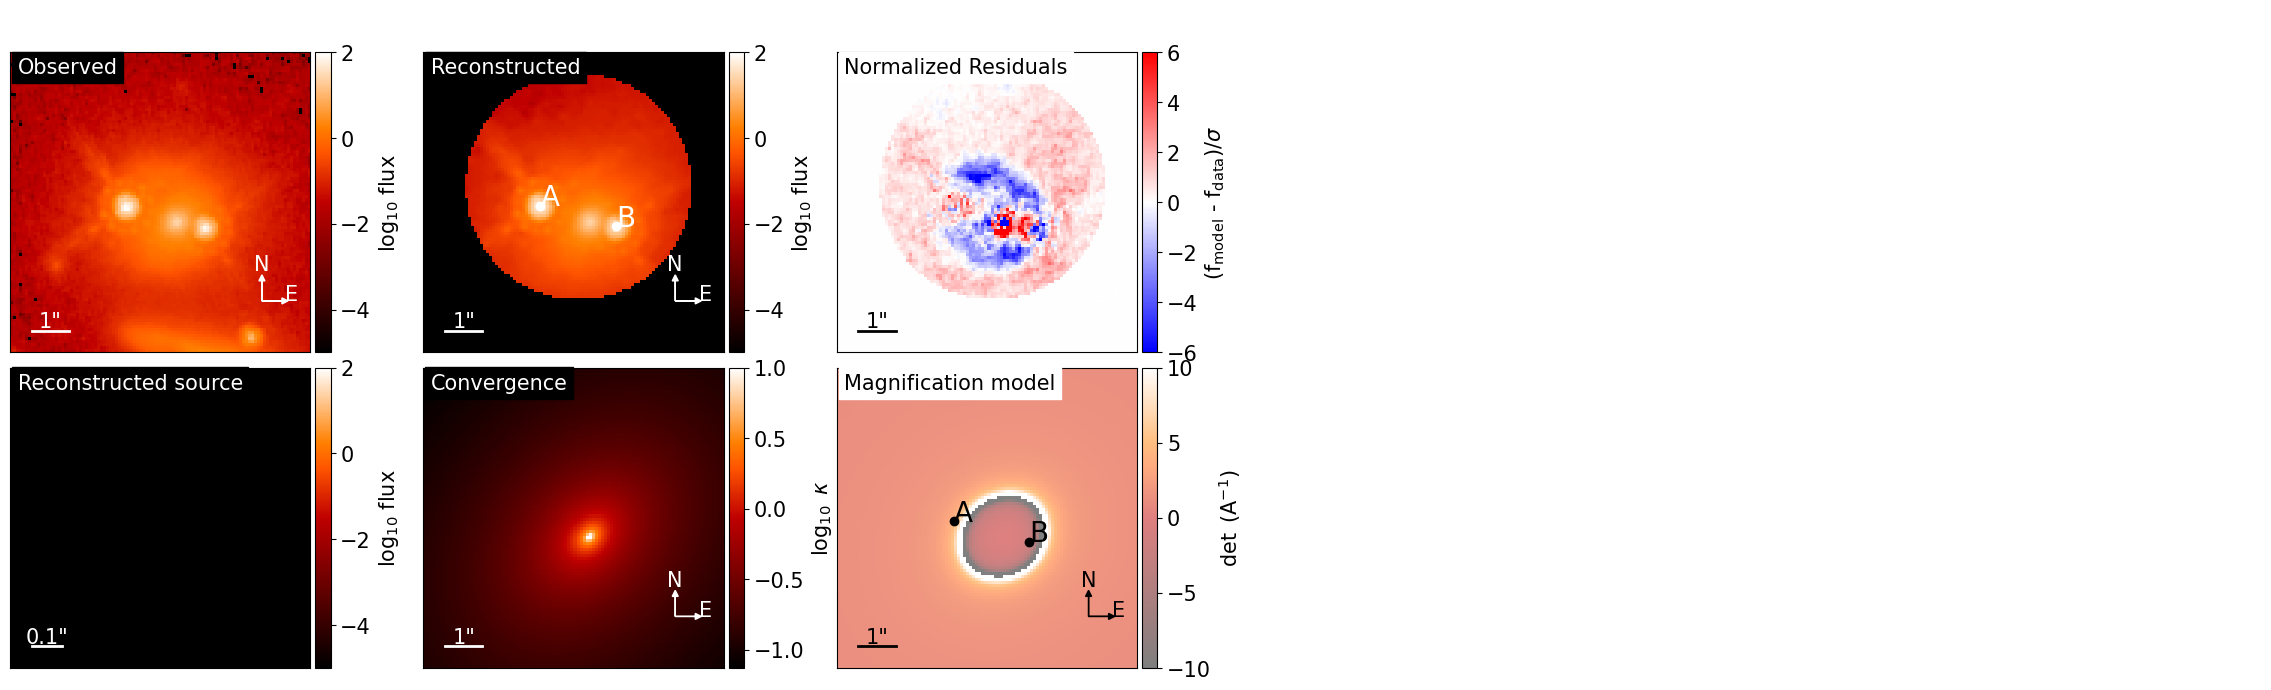

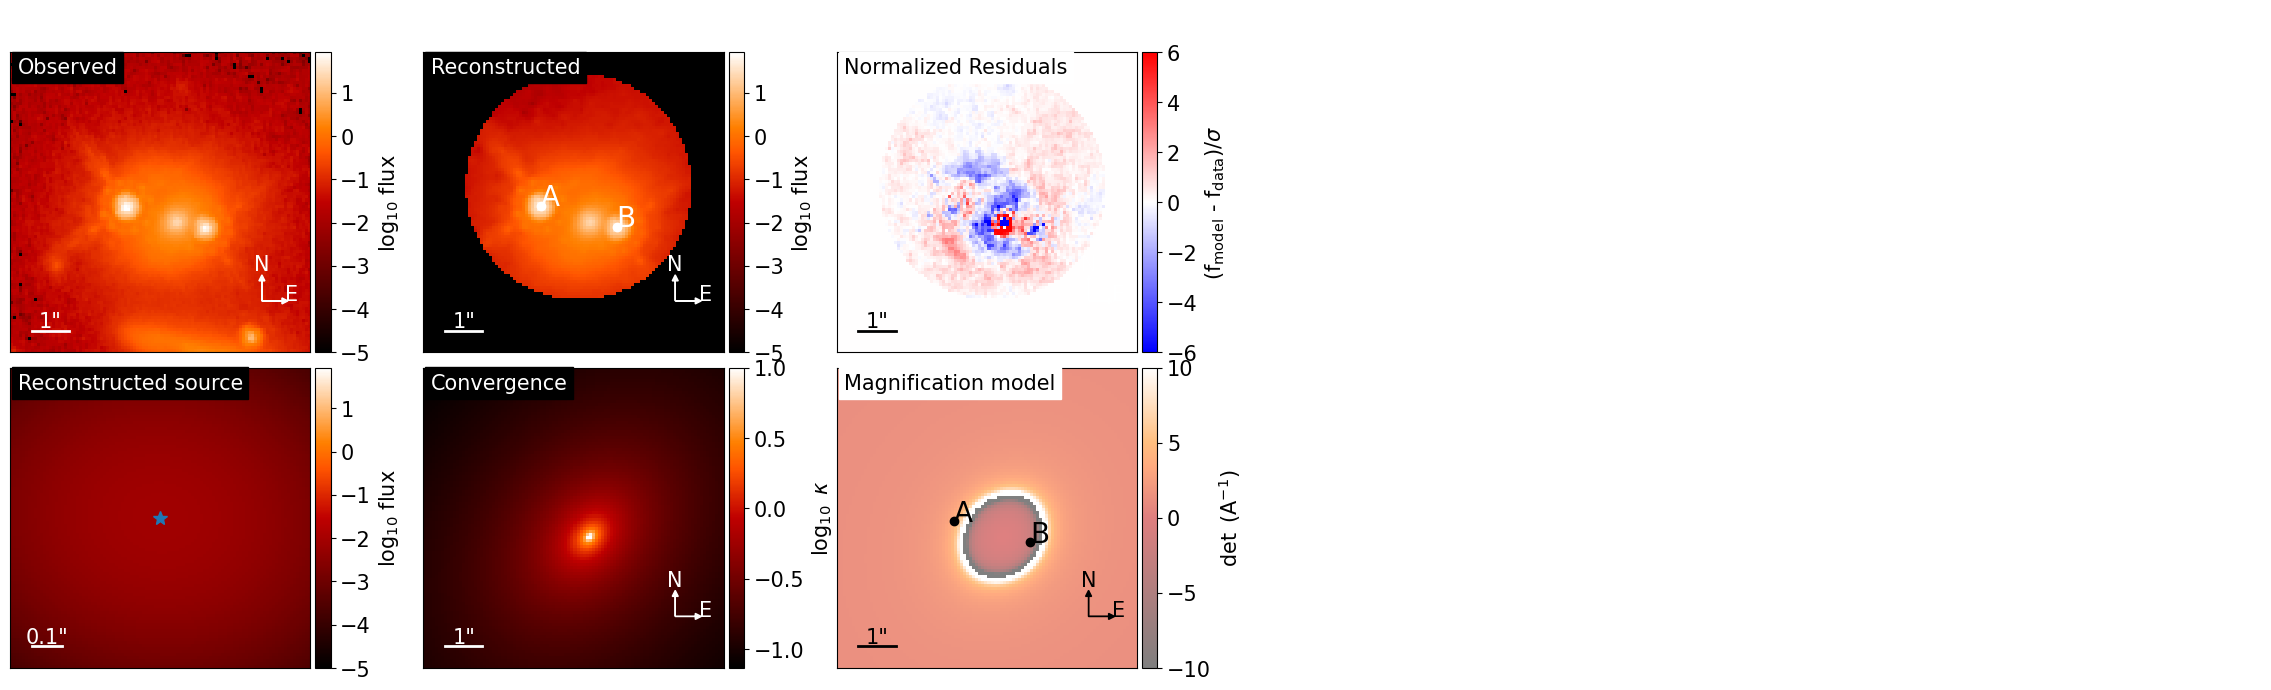

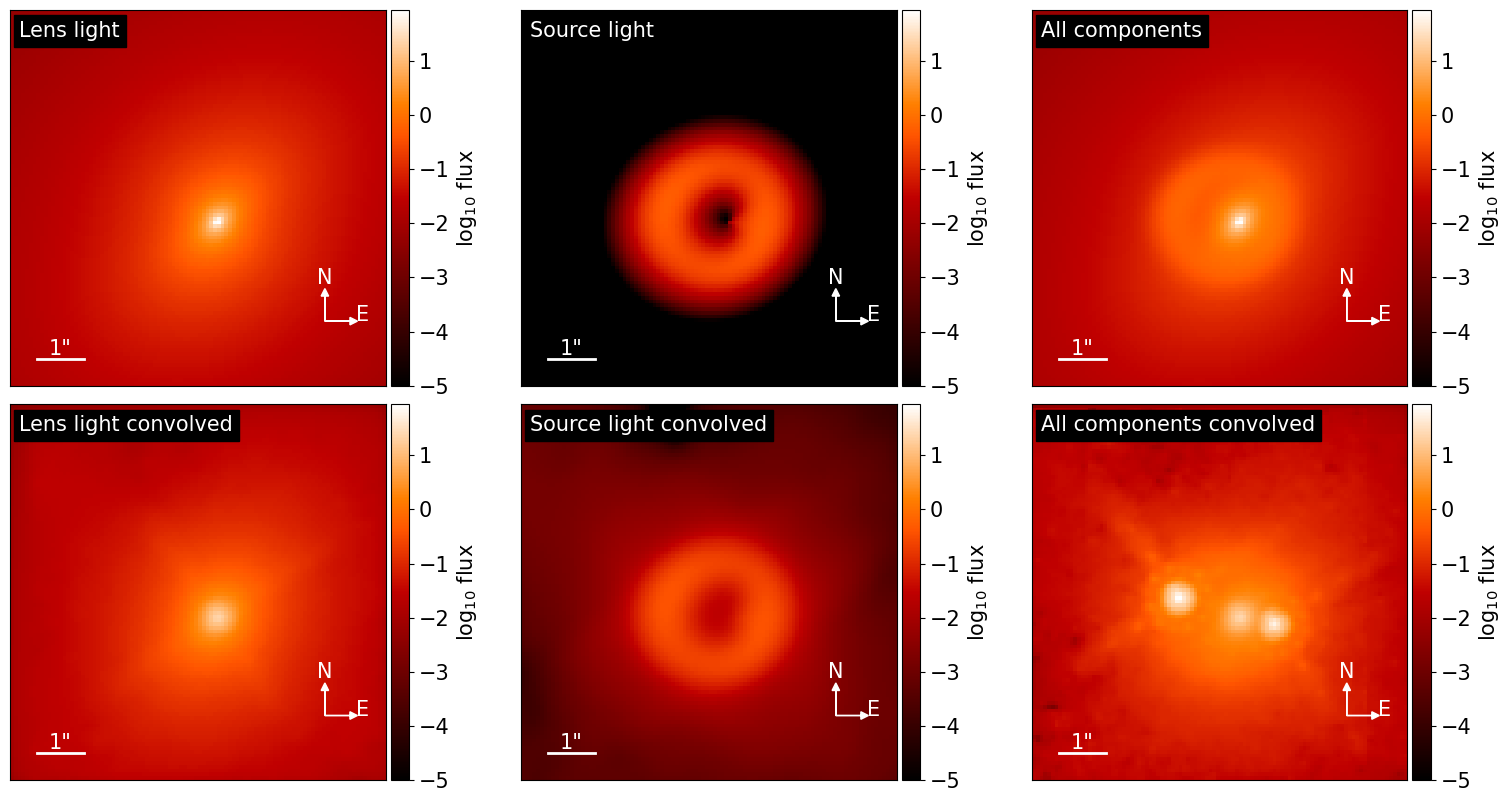

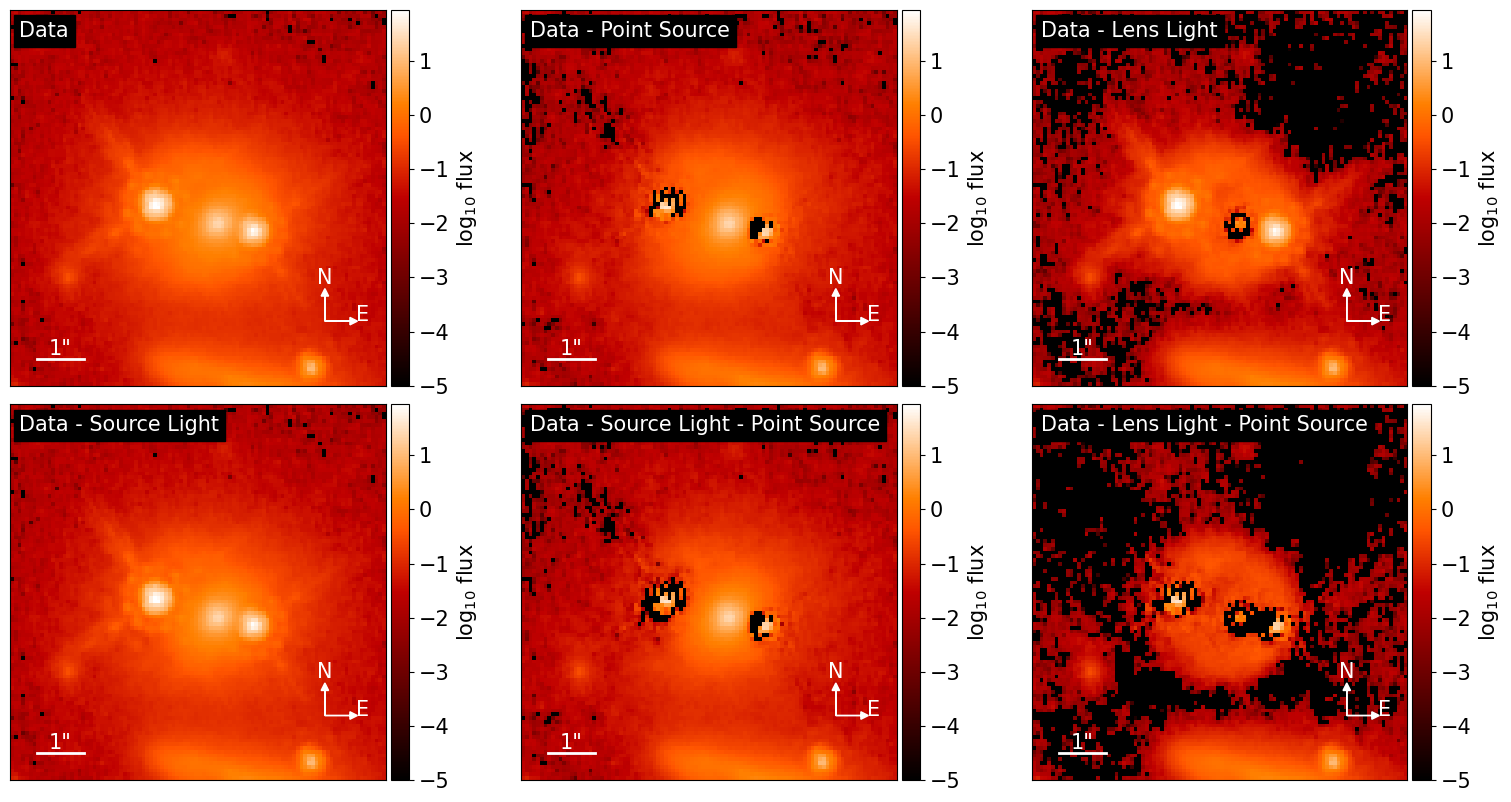

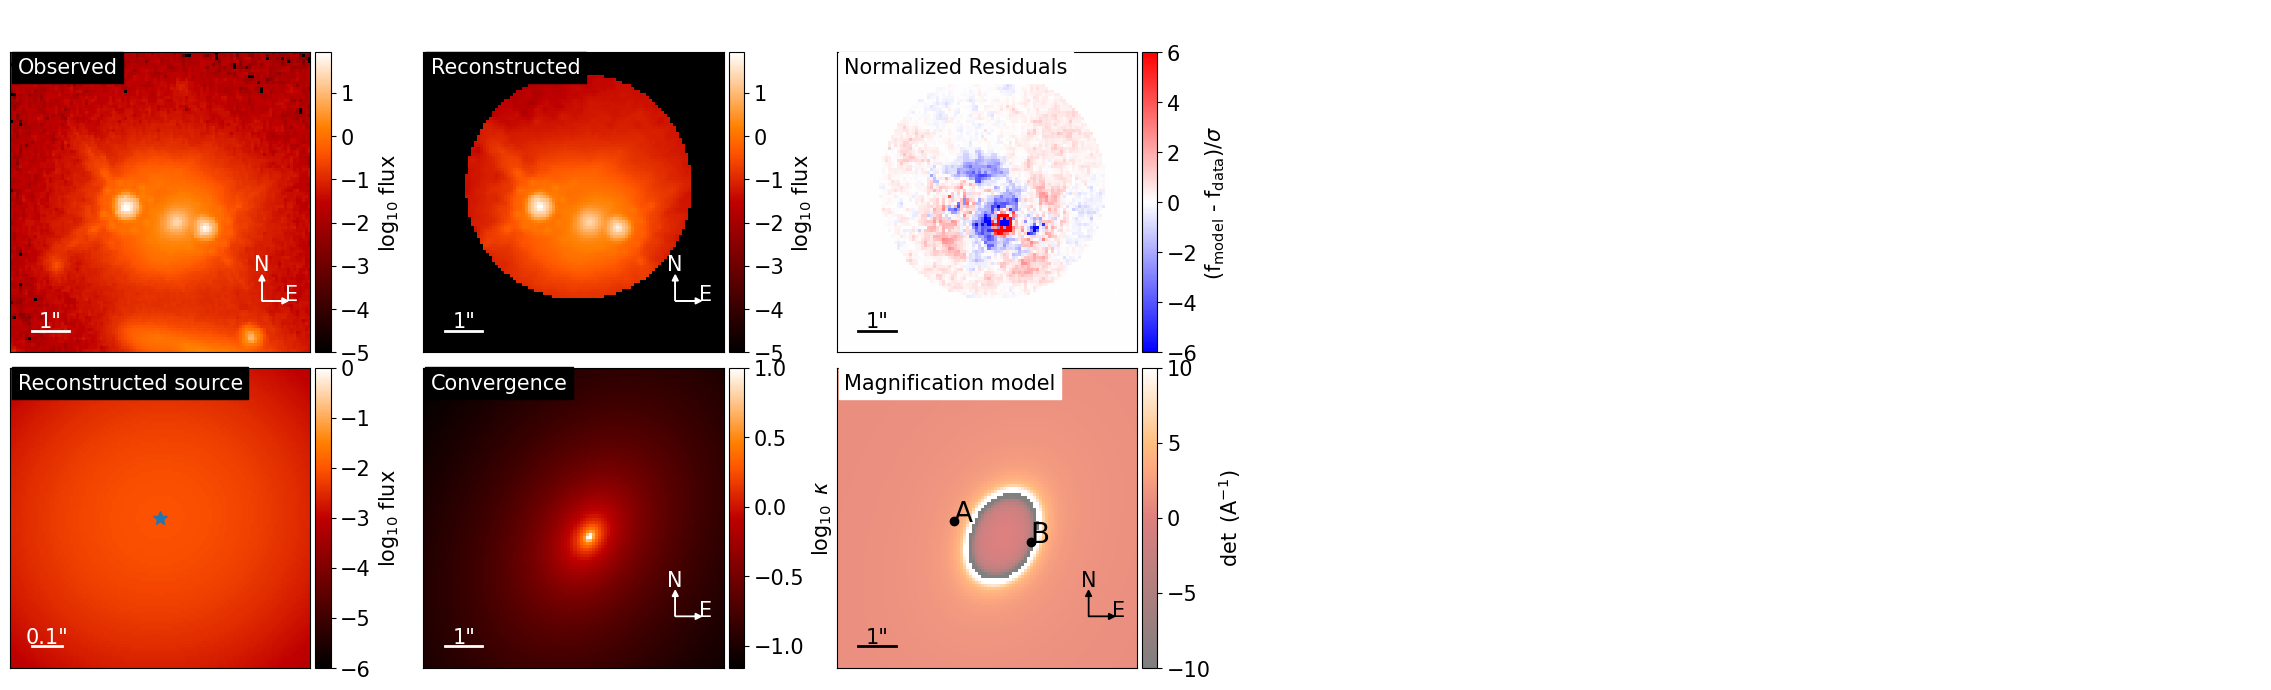

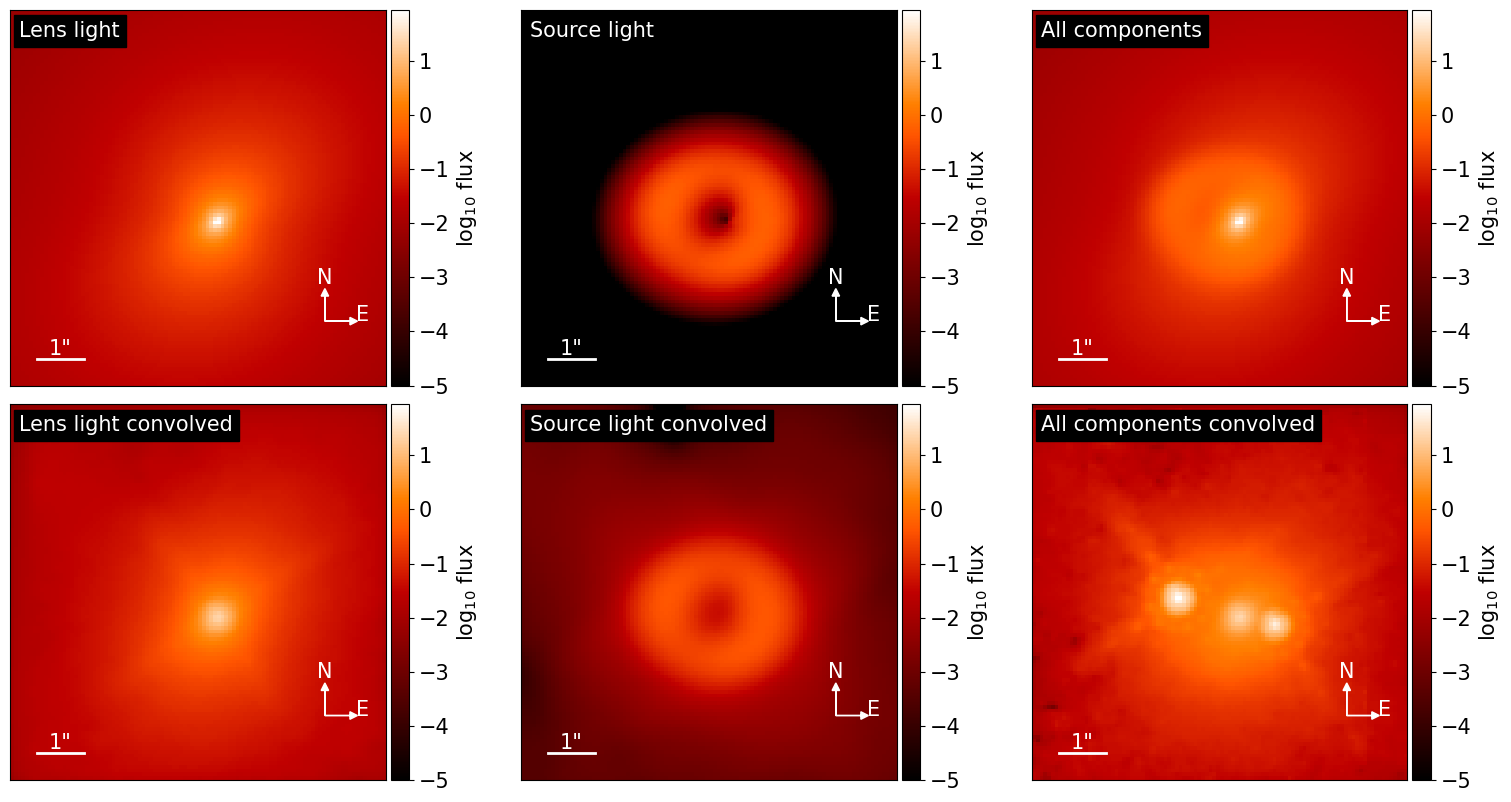

########################################################


/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:224: RuntimeWarning: invalid value encountered in log10
  np.log10(self._model),


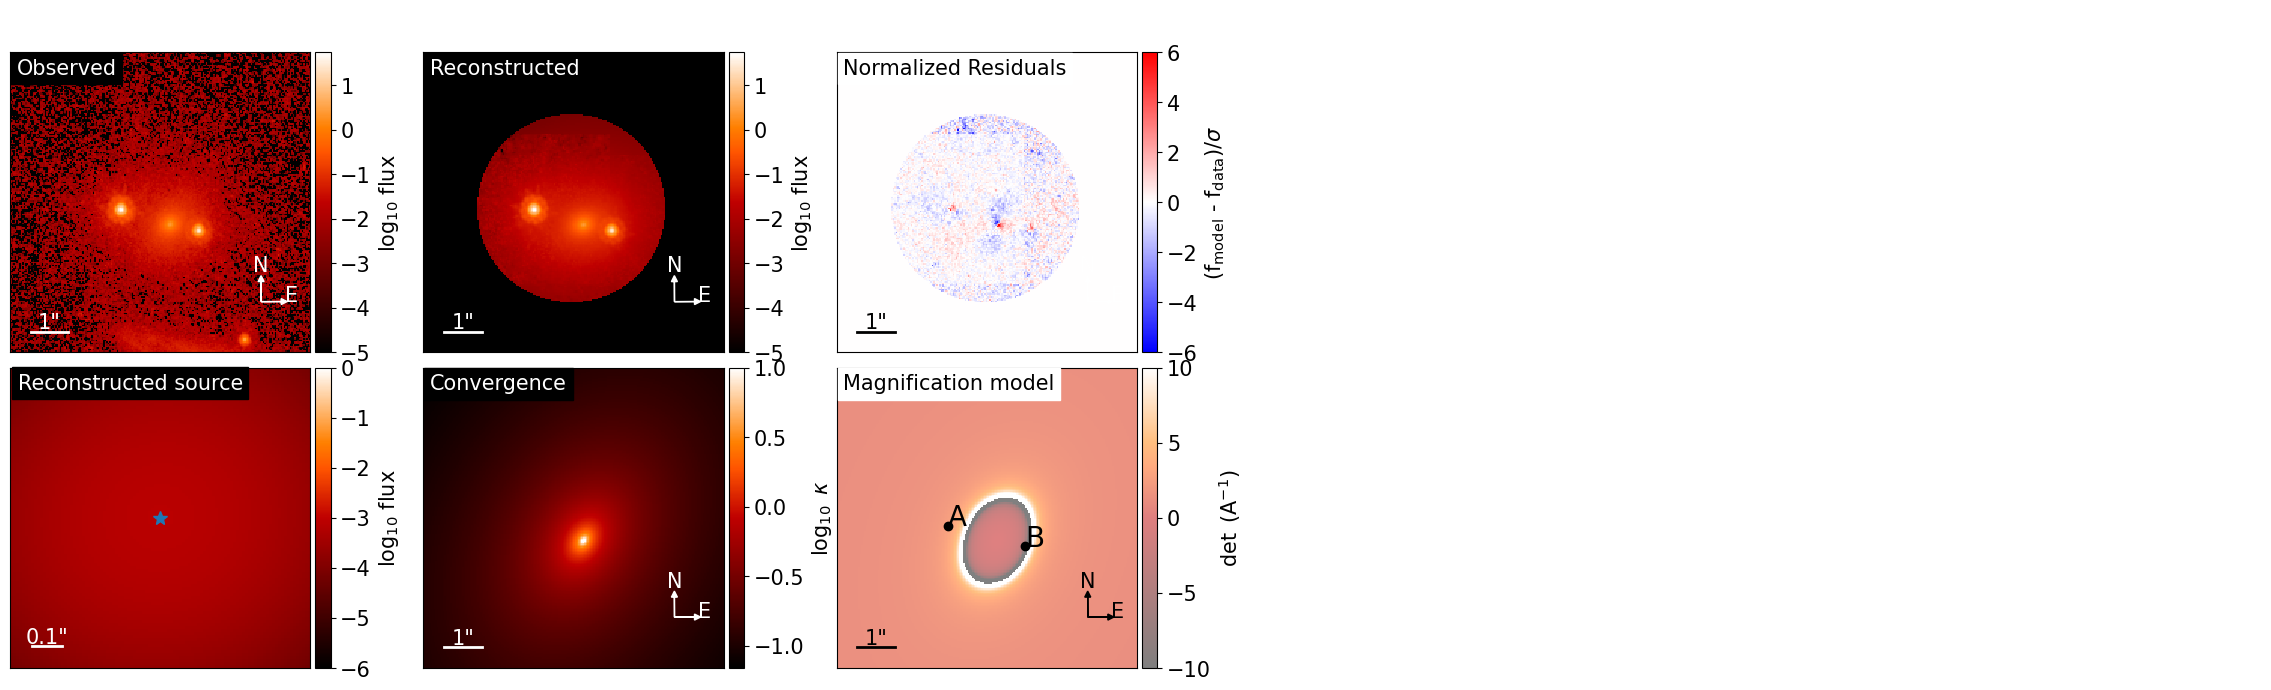

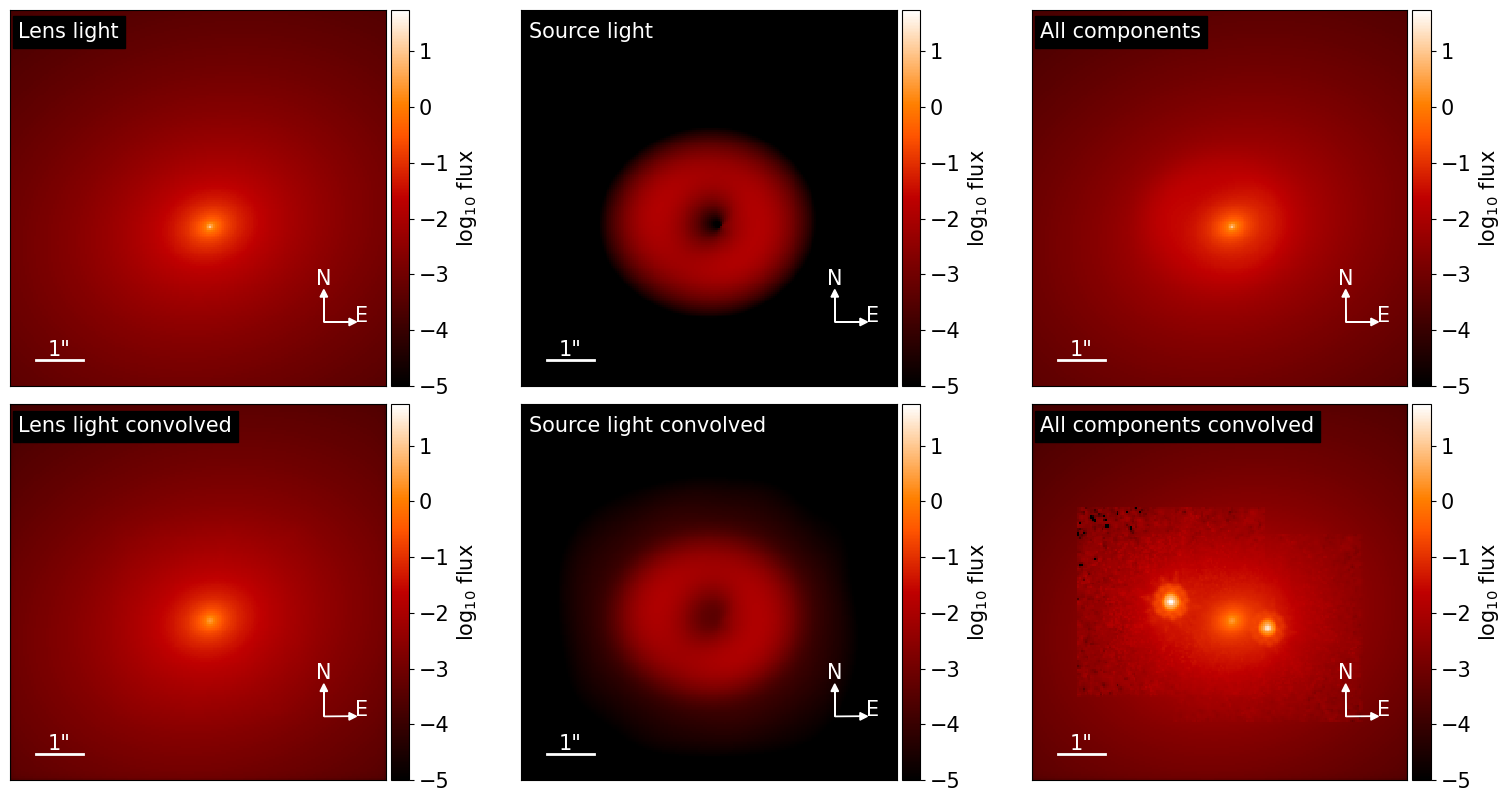

In [24]:
# we need to extract the updated multi_band_list object since the coordinate shifts were updated in the kwargs_data portions of it
multi_band_list_out = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")

def plot_band(modelPlot, band_index_plot):
    """
    a set of plotting routines for a ModelPlot() instance with specified band
    """

    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    modelPlot.data_plot(ax=axes[0,0], band_index=band_index_plot)
    modelPlot.model_plot(ax=axes[0,1], band_index=band_index_plot)
    modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6, band_index=band_index_plot)
    modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100,  v_min=-6, v_max=0, band_index=band_index_plot)
    modelPlot.convergence_plot(ax=axes[1, 1], v_max=1, band_index=band_index_plot)
    modelPlot.magnification_plot(ax=axes[1, 2], band_index=band_index_plot)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()

    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    modelPlot.decomposition_plot(ax=axes[0,0], band_index=band_index_plot, text='Lens light', lens_light_add=True, unconvolved=True)
    modelPlot.decomposition_plot(ax=axes[1,0], band_index=band_index_plot, text='Lens light convolved', lens_light_add=True)
    modelPlot.decomposition_plot(ax=axes[0,1], band_index=band_index_plot, text='Source light', source_add=True, unconvolved=True)
    modelPlot.decomposition_plot(ax=axes[1,1], band_index=band_index_plot, text='Source light convolved', source_add=True)
    modelPlot.decomposition_plot(ax=axes[0,2], band_index=band_index_plot, text='All components', source_add=True, lens_light_add=True, unconvolved=True)
    modelPlot.decomposition_plot(ax=axes[1,2], band_index=band_index_plot, text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    
plot_band(modelPlot, band_index_plot=0)
print('########################################################')
plot_band(modelPlot, band_index_plot=1)

In [25]:
def align_images():
    
    fitting_kwargs_list = [
        ['align_images', {'n_particles': 100, 'n_iterations': 100, 
                      'align_offset': True, 'align_rotation': True, 
                      'delta_shift': 10., 'delta_rot': .5,
                      'compute_bands': [False, False, True]}],  # align second image
        ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, True]},  # now fit all bands jointly
                        }], 
        ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 250}],  # run PSO of all bands
        ]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    new_multiband = fitting_seq.multi_band_list

    return chain_list, kwargs_result, new_multiband

chain_list, kwargs_result, new_multiband = align_images()

Computing the Alignment fitting for band 2 ... ...


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:09<15:06,  9.16s/it]

  2%|▏         | 2/100 [00:13<10:36,  6.49s/it]

  3%|▎         | 3/100 [00:18<09:05,  5.62s/it]

  4%|▍         | 4/100 [00:22<08:21,  5.22s/it]

  5%|▌         | 5/100 [00:27<07:55,  5.01s/it]

  6%|▌         | 6/100 [00:32<07:38,  4.88s/it]

  7%|▋         | 7/100 [00:36<07:26,  4.80s/it]

  8%|▊         | 8/100 [00:41<07:17,  4.75s/it]

  9%|▉         | 9/100 [00:46<07:09,  4.72s/it]

 10%|█         | 10/100 [00:50<07:02,  4.70s/it]

 11%|█         | 11/100 [00:55<06:57,  4.69s/it]

 12%|█▏        | 12/100 [01:00<06:51,  4.67s/it]

 13%|█▎        | 13/100 [01:04<06:46,  4.67s/it]

 14%|█▍        | 14/100 [01:09<06:41,  4.67s/it]

 15%|█▌        | 15/100 [01:14<06:36,  4.66s/it]

 16%|█▌        | 16/100 [01:18<06:31,  4.66s/it]

 17%|█▋        | 17/100 [01:23<06:27,  4.67s/it]

 18%|█▊        | 18/100 [01:28<06:22,  4.67s/it]

 19%|█▉        | 19/100 [01:32<06:18,  4.67s/it]

 20%|██        | 20/100 [01:37<06:13,  4.67s/it]

 21%|██        | 21/100 [01:42<06:08,  4.67s/it]

 22%|██▏       | 22/100 [01:46<06:03,  4.67s/it]

 23%|██▎       | 23/100 [01:51<05:59,  4.67s/it]

 24%|██▍       | 24/100 [01:56<05:54,  4.67s/it]

 25%|██▌       | 25/100 [02:00<05:50,  4.67s/it]

 26%|██▌       | 26/100 [02:05<05:45,  4.67s/it]

 27%|██▋       | 27/100 [02:10<05:40,  4.67s/it]

 28%|██▊       | 28/100 [02:14<05:36,  4.67s/it]

 29%|██▉       | 29/100 [02:19<05:31,  4.67s/it]

 30%|███       | 30/100 [02:24<05:27,  4.67s/it]

 31%|███       | 31/100 [02:28<05:22,  4.67s/it]

 32%|███▏      | 32/100 [02:33<05:17,  4.67s/it]

 33%|███▎      | 33/100 [02:38<05:13,  4.69s/it]

 34%|███▍      | 34/100 [02:42<05:09,  4.69s/it]

 35%|███▌      | 35/100 [02:47<05:04,  4.69s/it]

 36%|███▌      | 36/100 [02:52<04:59,  4.69s/it]

 37%|███▋      | 37/100 [02:56<04:54,  4.68s/it]

 38%|███▊      | 38/100 [03:01<04:50,  4.68s/it]

 39%|███▉      | 39/100 [03:06<04:45,  4.68s/it]

 40%|████      | 40/100 [03:10<04:40,  4.68s/it]

 41%|████      | 41/100 [03:15<04:35,  4.68s/it]

 42%|████▏     | 42/100 [03:20<04:31,  4.68s/it]

 43%|████▎     | 43/100 [03:24<04:26,  4.68s/it]

 44%|████▍     | 44/100 [03:29<04:21,  4.68s/it]

 45%|████▌     | 45/100 [03:34<04:17,  4.68s/it]

 46%|████▌     | 46/100 [03:38<04:12,  4.68s/it]

 47%|████▋     | 47/100 [03:43<04:07,  4.68s/it]

 48%|████▊     | 48/100 [03:48<04:03,  4.68s/it]

 49%|████▉     | 49/100 [03:53<03:58,  4.68s/it]

 50%|█████     | 50/100 [03:57<03:53,  4.68s/it]

 51%|█████     | 51/100 [04:02<03:49,  4.68s/it]

 52%|█████▏    | 52/100 [04:07<03:44,  4.67s/it]

 53%|█████▎    | 53/100 [04:11<03:39,  4.67s/it]

 54%|█████▍    | 54/100 [04:16<03:35,  4.67s/it]

 55%|█████▌    | 55/100 [04:21<03:30,  4.67s/it]

 56%|█████▌    | 56/100 [04:25<03:26,  4.68s/it]

 57%|█████▋    | 57/100 [04:30<03:21,  4.68s/it]

 58%|█████▊    | 58/100 [04:35<03:16,  4.68s/it]

 59%|█████▉    | 59/100 [04:39<03:12,  4.68s/it]

 60%|██████    | 60/100 [04:44<03:07,  4.68s/it]

 61%|██████    | 61/100 [04:49<03:02,  4.68s/it]

 62%|██████▏   | 62/100 [04:53<02:57,  4.68s/it]

 63%|██████▎   | 63/100 [04:58<02:53,  4.68s/it]

 64%|██████▍   | 64/100 [05:03<02:48,  4.68s/it]

 65%|██████▌   | 65/100 [05:07<02:43,  4.68s/it]

 66%|██████▌   | 66/100 [05:12<02:38,  4.67s/it]

 67%|██████▋   | 67/100 [05:17<02:34,  4.67s/it]

 68%|██████▊   | 68/100 [05:21<02:29,  4.68s/it]

 69%|██████▉   | 69/100 [05:26<02:24,  4.68s/it]

 70%|███████   | 70/100 [05:31<02:20,  4.67s/it]

 71%|███████   | 71/100 [05:35<02:15,  4.68s/it]

 72%|███████▏  | 72/100 [05:40<02:10,  4.67s/it]

 73%|███████▎  | 73/100 [05:45<02:06,  4.67s/it]

 74%|███████▍  | 74/100 [05:49<02:01,  4.67s/it]

 75%|███████▌  | 75/100 [05:54<01:56,  4.68s/it]

 76%|███████▌  | 76/100 [05:59<01:52,  4.67s/it]

 77%|███████▋  | 77/100 [06:03<01:47,  4.67s/it]

 78%|███████▊  | 78/100 [06:08<01:42,  4.67s/it]

 79%|███████▉  | 79/100 [06:13<01:38,  4.67s/it]

 80%|████████  | 80/100 [06:17<01:33,  4.67s/it]

 81%|████████  | 81/100 [06:22<01:28,  4.67s/it]

 82%|████████▏ | 82/100 [06:27<01:24,  4.67s/it]

 83%|████████▎ | 83/100 [06:31<01:19,  4.67s/it]

 84%|████████▍ | 84/100 [06:36<01:14,  4.67s/it]

 85%|████████▌ | 85/100 [06:41<01:10,  4.68s/it]

 86%|████████▌ | 86/100 [06:46<01:05,  4.68s/it]

 87%|████████▋ | 87/100 [06:50<01:00,  4.68s/it]

 88%|████████▊ | 88/100 [06:55<00:56,  4.68s/it]

 89%|████████▉ | 89/100 [07:00<00:51,  4.68s/it]

 90%|█████████ | 90/100 [07:04<00:46,  4.68s/it]

 91%|█████████ | 91/100 [07:09<00:42,  4.68s/it]

 92%|█████████▏| 92/100 [07:14<00:37,  4.68s/it]

 93%|█████████▎| 93/100 [07:18<00:32,  4.68s/it]

 94%|█████████▍| 94/100 [07:23<00:28,  4.68s/it]

 95%|█████████▌| 95/100 [07:28<00:23,  4.68s/it]

 96%|█████████▌| 96/100 [07:32<00:18,  4.68s/it]

 97%|█████████▋| 97/100 [07:37<00:14,  4.67s/it]

 98%|█████████▊| 98/100 [07:42<00:09,  4.67s/it]

 99%|█████████▉| 99/100 [07:46<00:04,  4.67s/it]

100%|██████████| 100/100 [07:51<00:00,  4.67s/it]

100%|██████████| 100/100 [07:51<00:00,  4.71s/it]

Max iteration reached! Stopping.
Shifts found:  [0.1013653209820784, 0.08989155416830594, -0.0024158779724386594]
471.48552536964417 time used for  Alignment fitting for band 2 ...
Align completed for band 2.
ra_shift: 0.1013653209820784,  dec_shift: 0.08989155416830594, phi_rot: -0.0024158779724386594


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [29:17<?, ?it/s]

In [26]:
#now we run an iterative PSF reconstruction on all three bands
kwargs_psf_iter.update({'compute_bands': [True, True, True]})

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

new_multiband = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]

iteration of step 0 gave best reconstruction.
log likelihood before: -4404.8106213751025 and log likelihood after: -4404.8106213751025


iteration of step 1 gave best reconstruction.
log likelihood before: -2511.9515325289053 and log likelihood after: -2463.768485940761


iteration of step 4 gave best reconstruction.
log likelihood before: -1837.4331669303388 and log likelihood after: -1516.8663667904257


-0.5789454207474655 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.9994601095653748
reduced chi^2 of data  1 =  0.40123255206265385
reduced chi^2 of data  2 =  0.24702652337601635


/tmp/ipykernel_1012239/1091800033.py:19: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


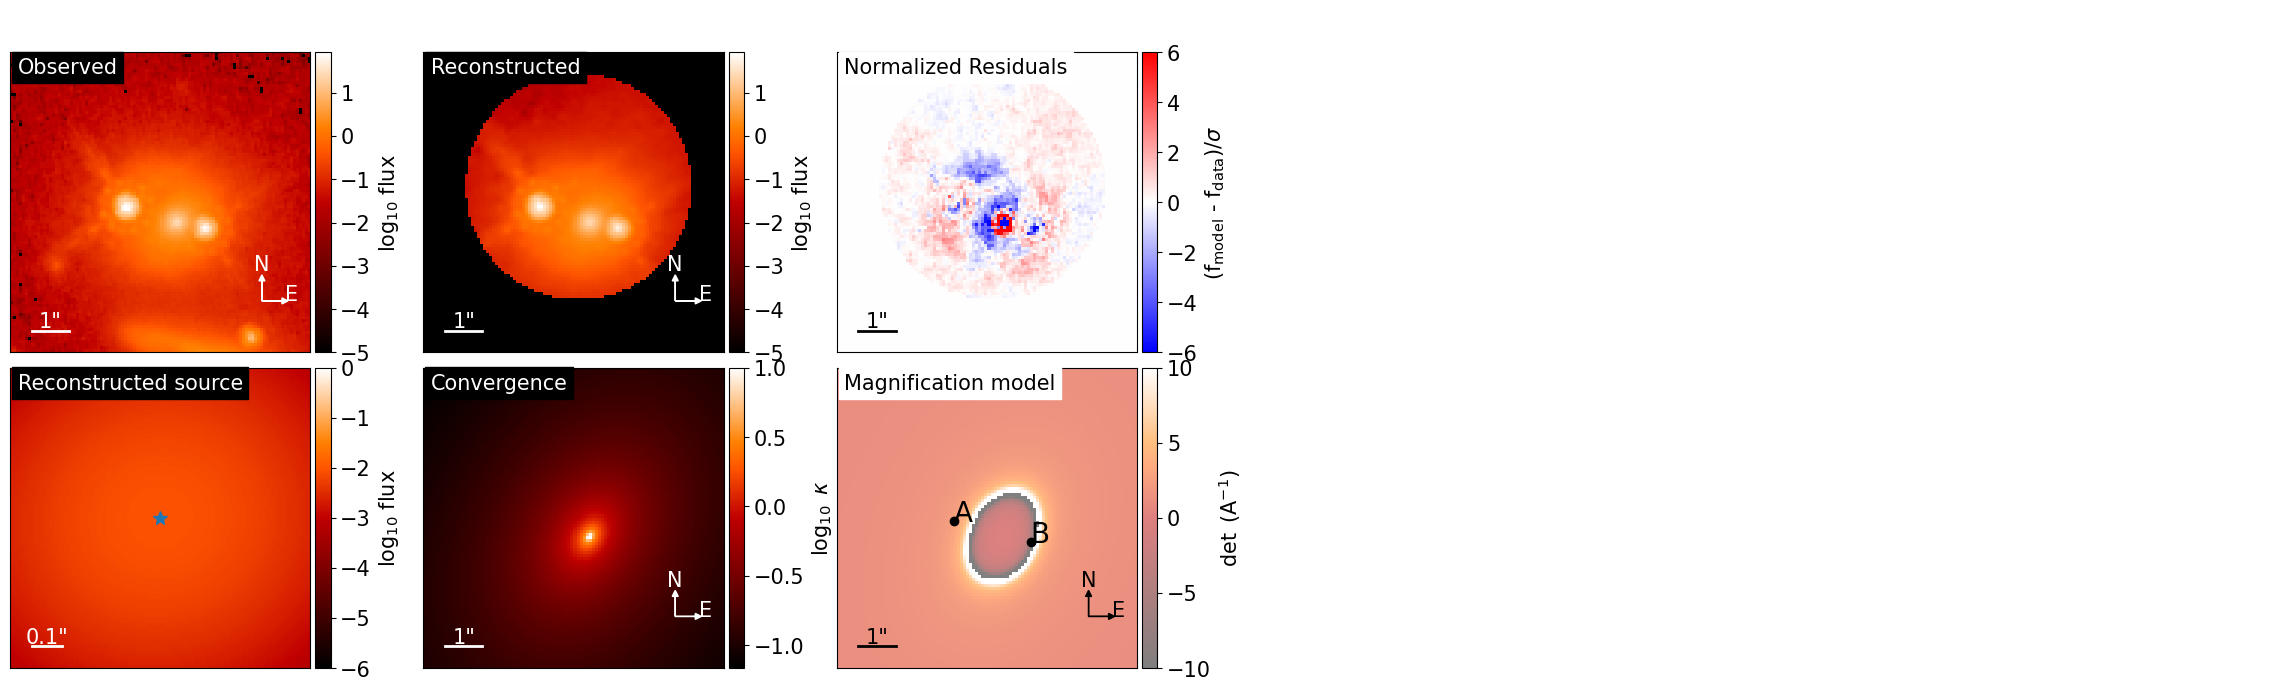

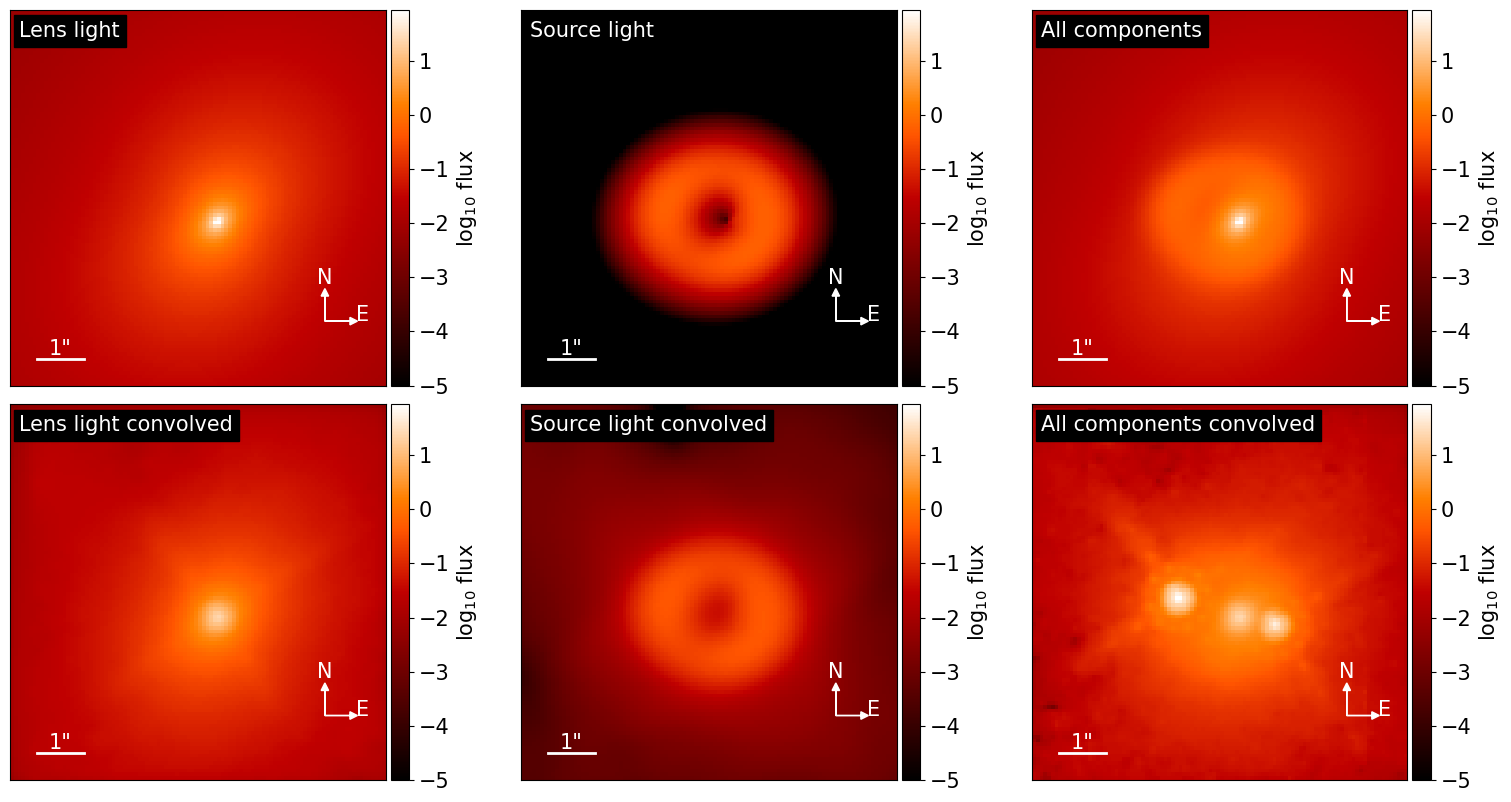

########################################################


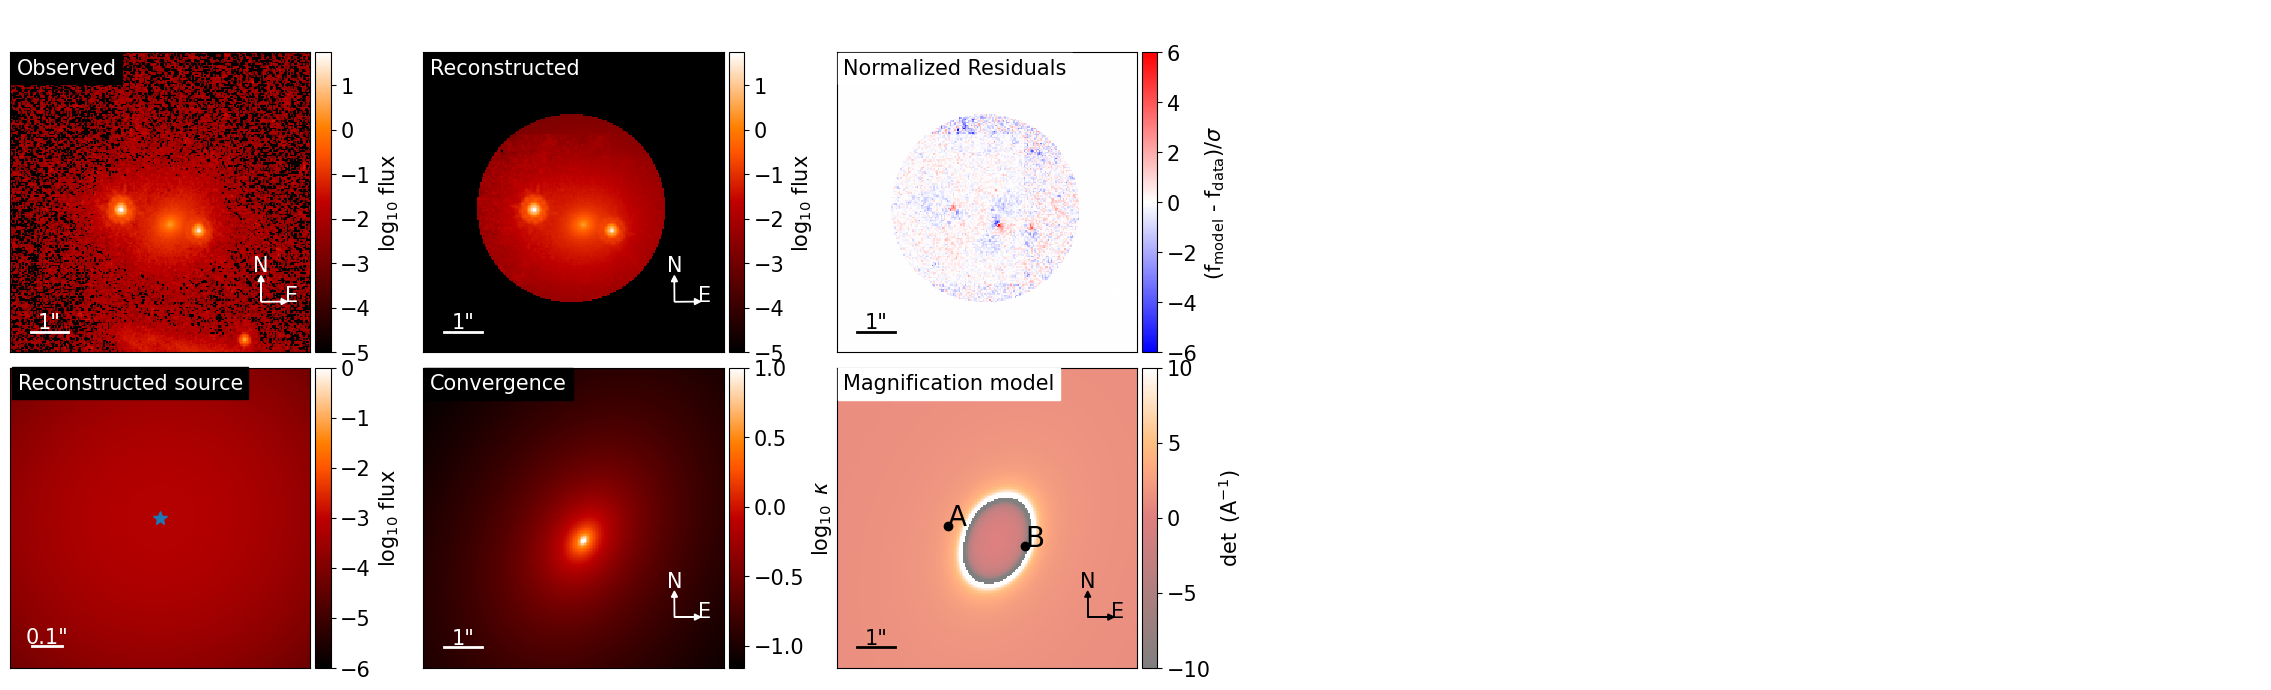

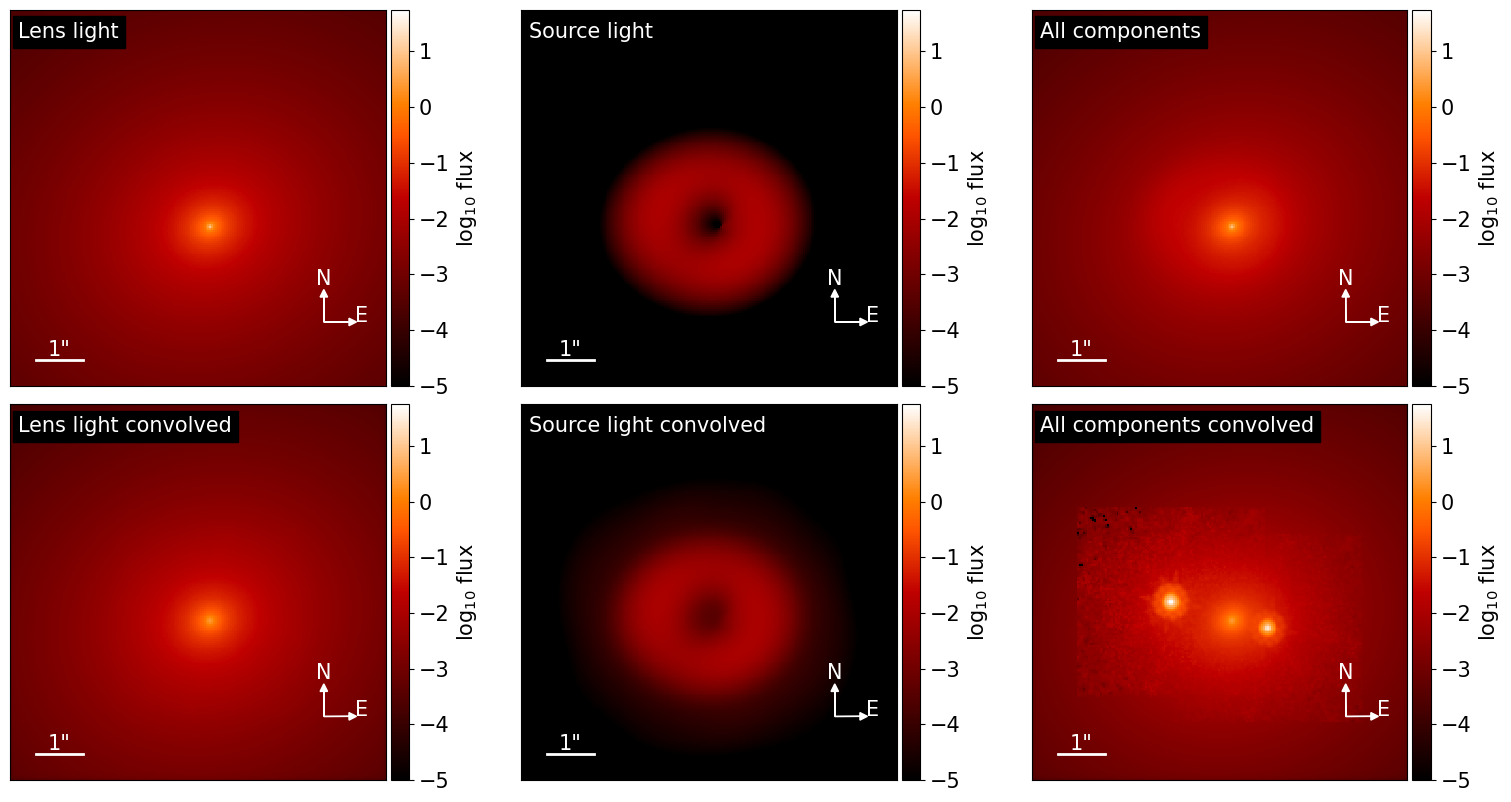

########################################################


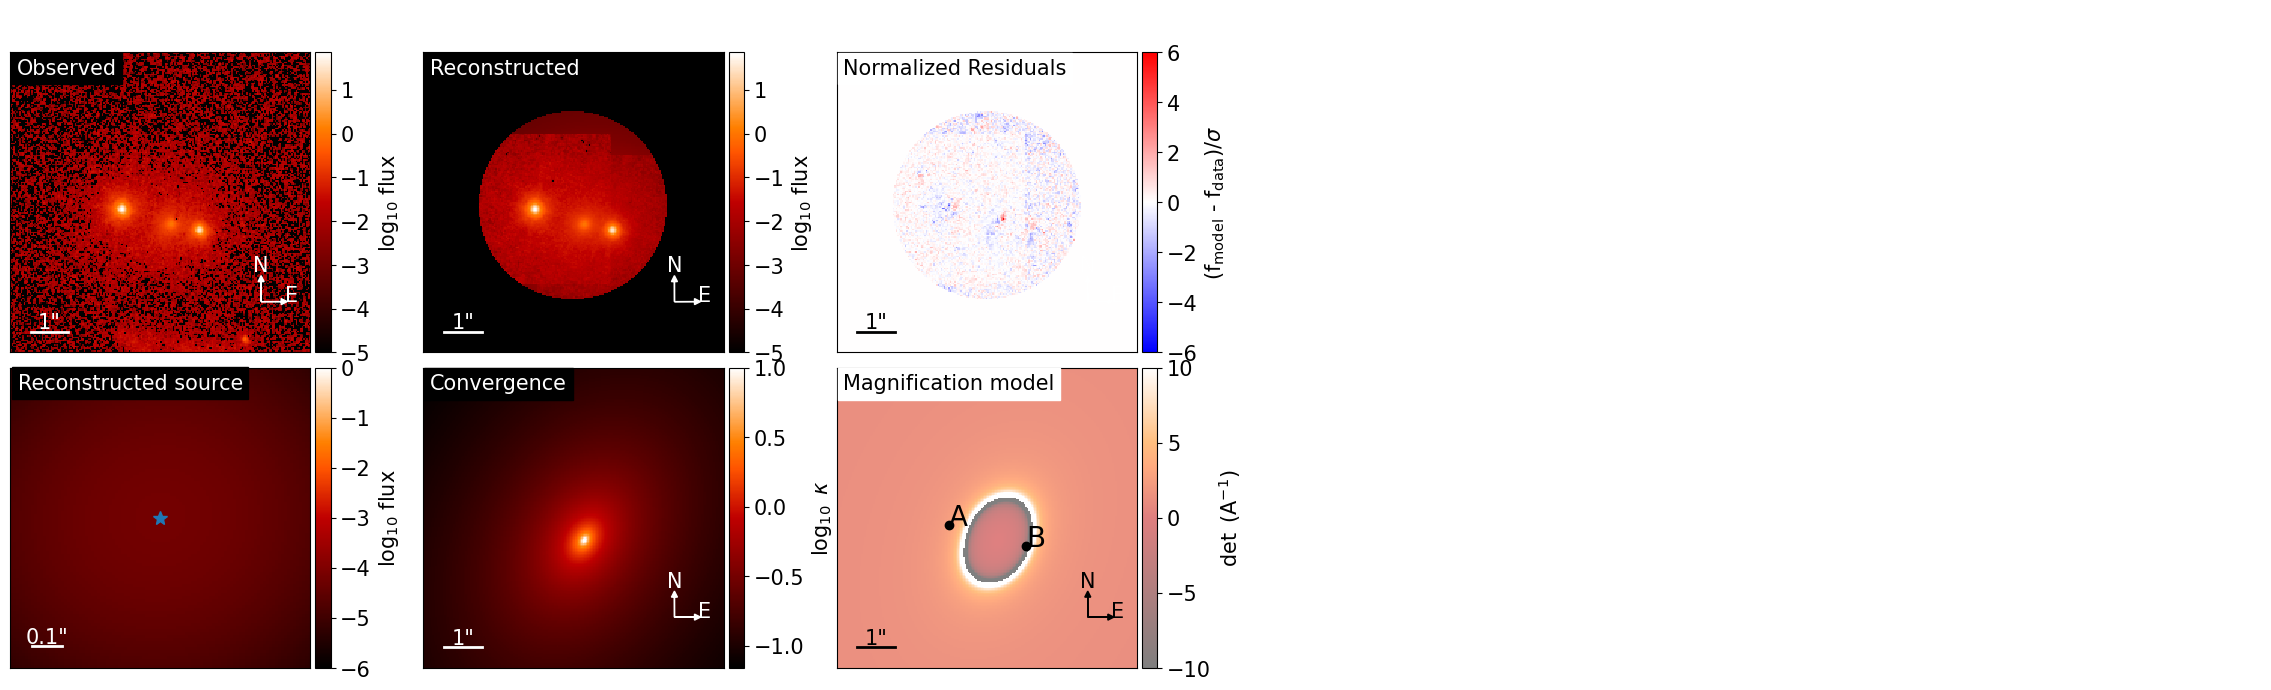

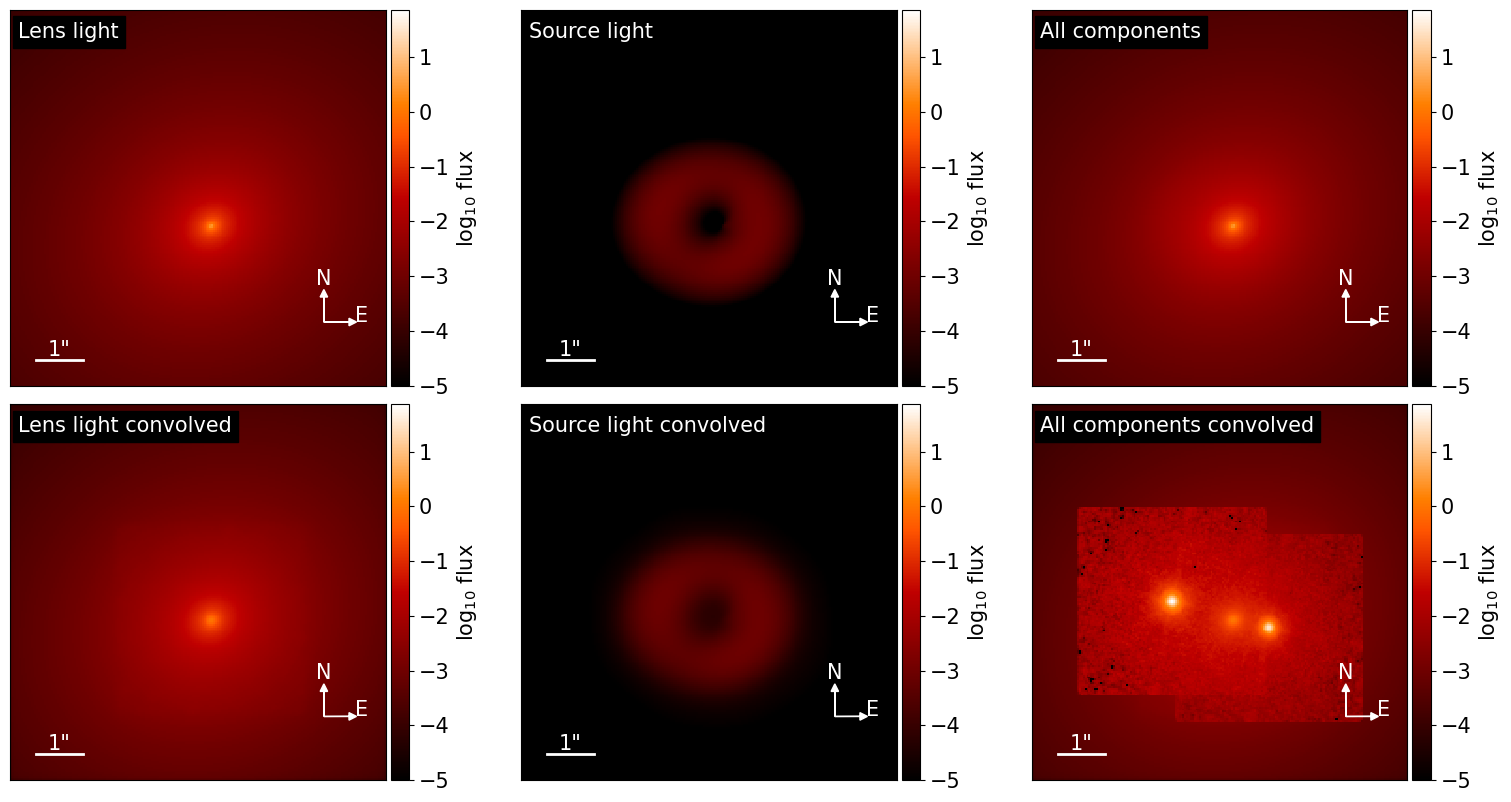

In [27]:
# we need to extract the updated multi_band_list object since the coordinate shifts were updated in the kwargs_data portions of it
multi_band_list_out = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")
    
plot_band(modelPlot, band_index_plot=0)
print('########################################################')
plot_band(modelPlot, band_index_plot=1)
print('########################################################')
plot_band(modelPlot, band_index_plot=2)

-0.5548862544512569 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.8463280135181546
reduced chi^2 of data  1 =  0.3986032432218098
reduced chi^2 of data  2 =  0.24784442320909397


/tmp/ipykernel_1012239/1091800033.py:19: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


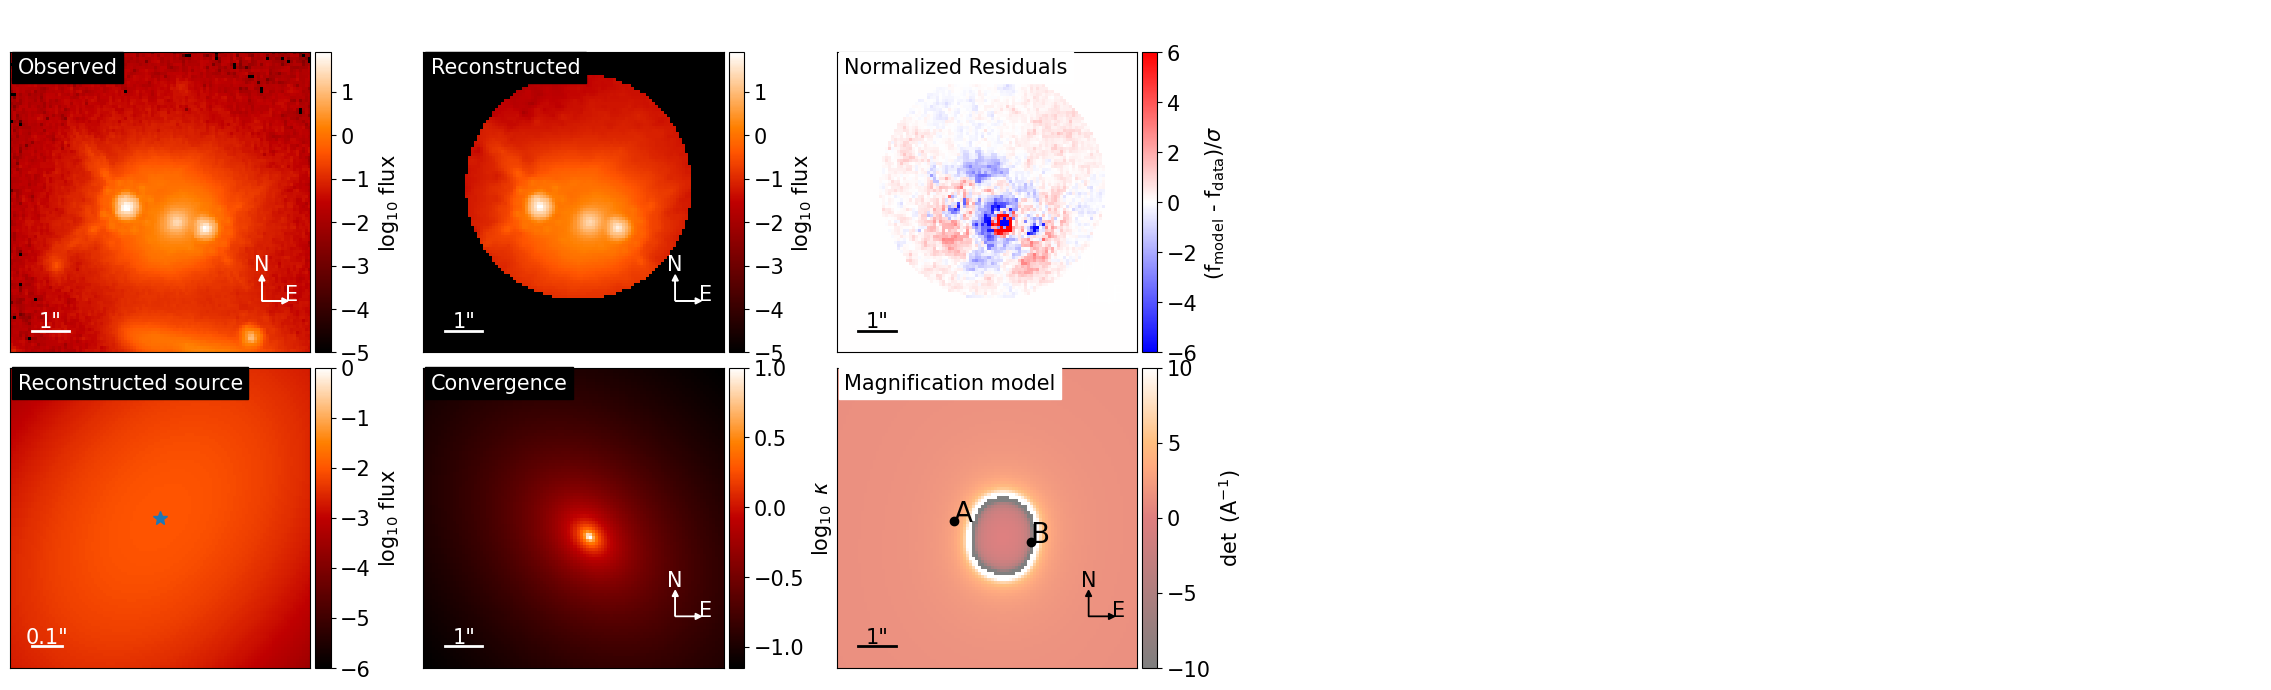

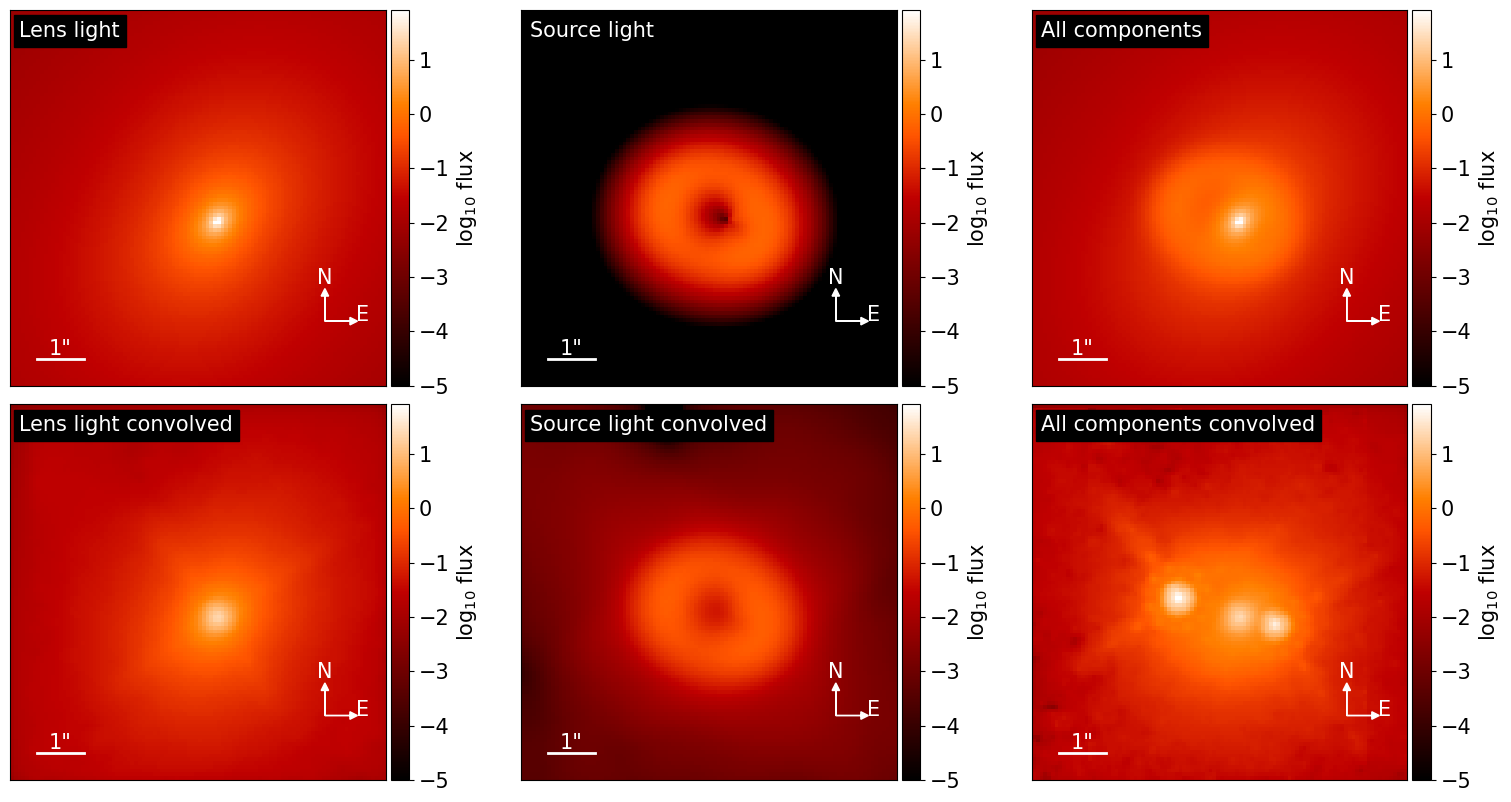

########################################################


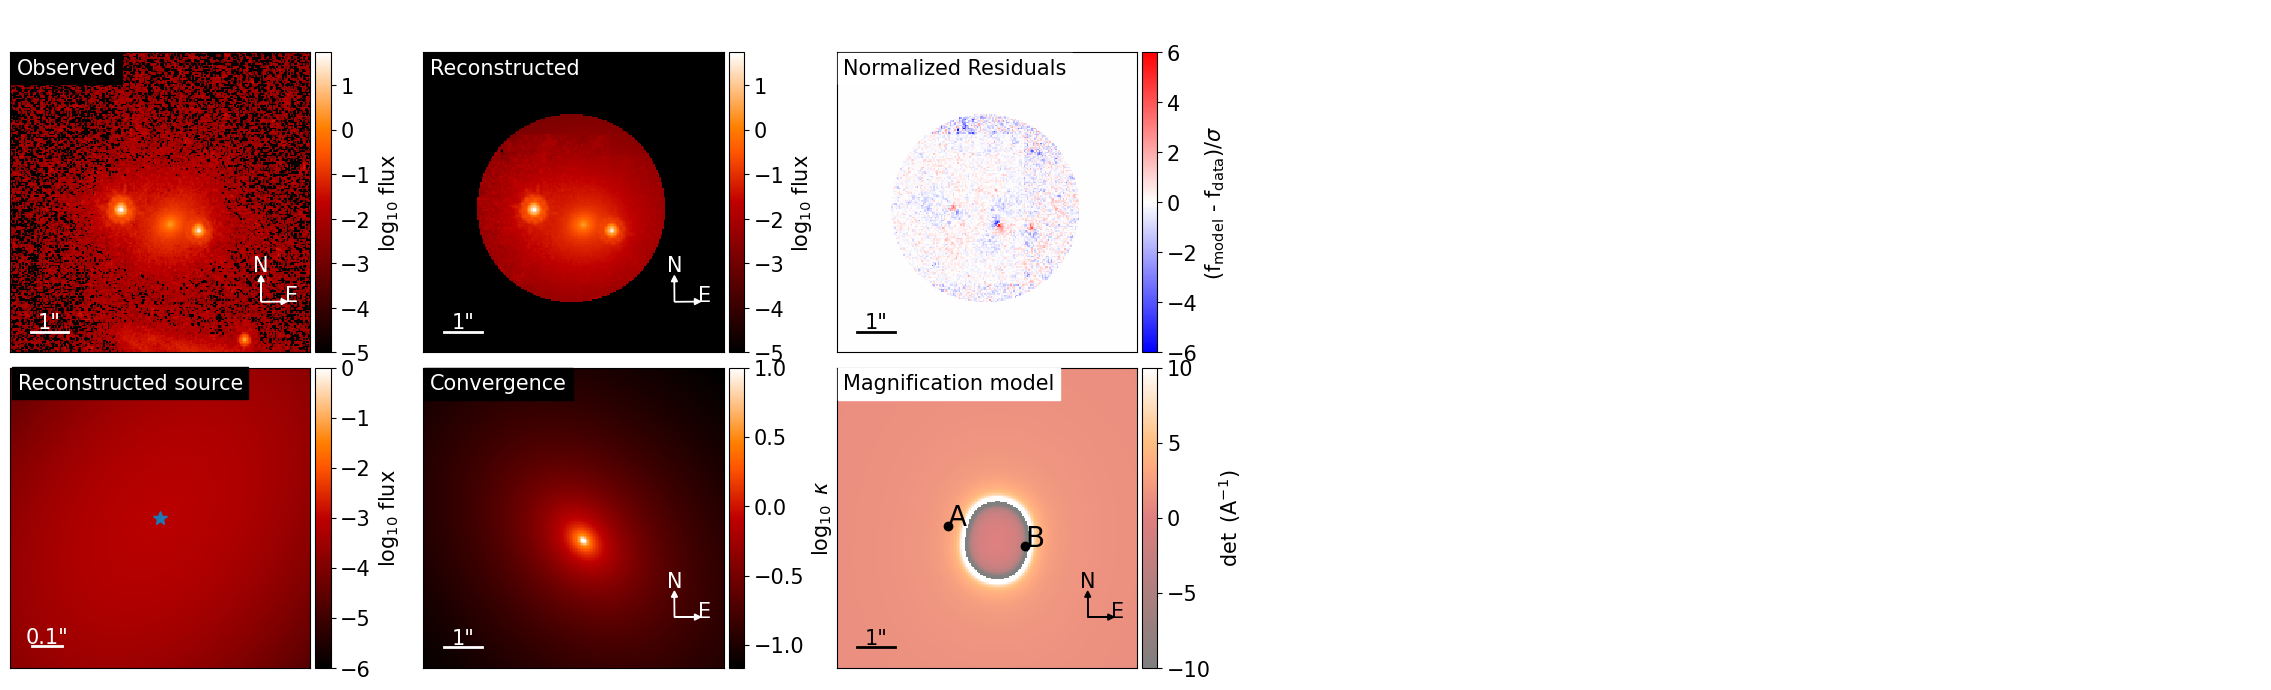

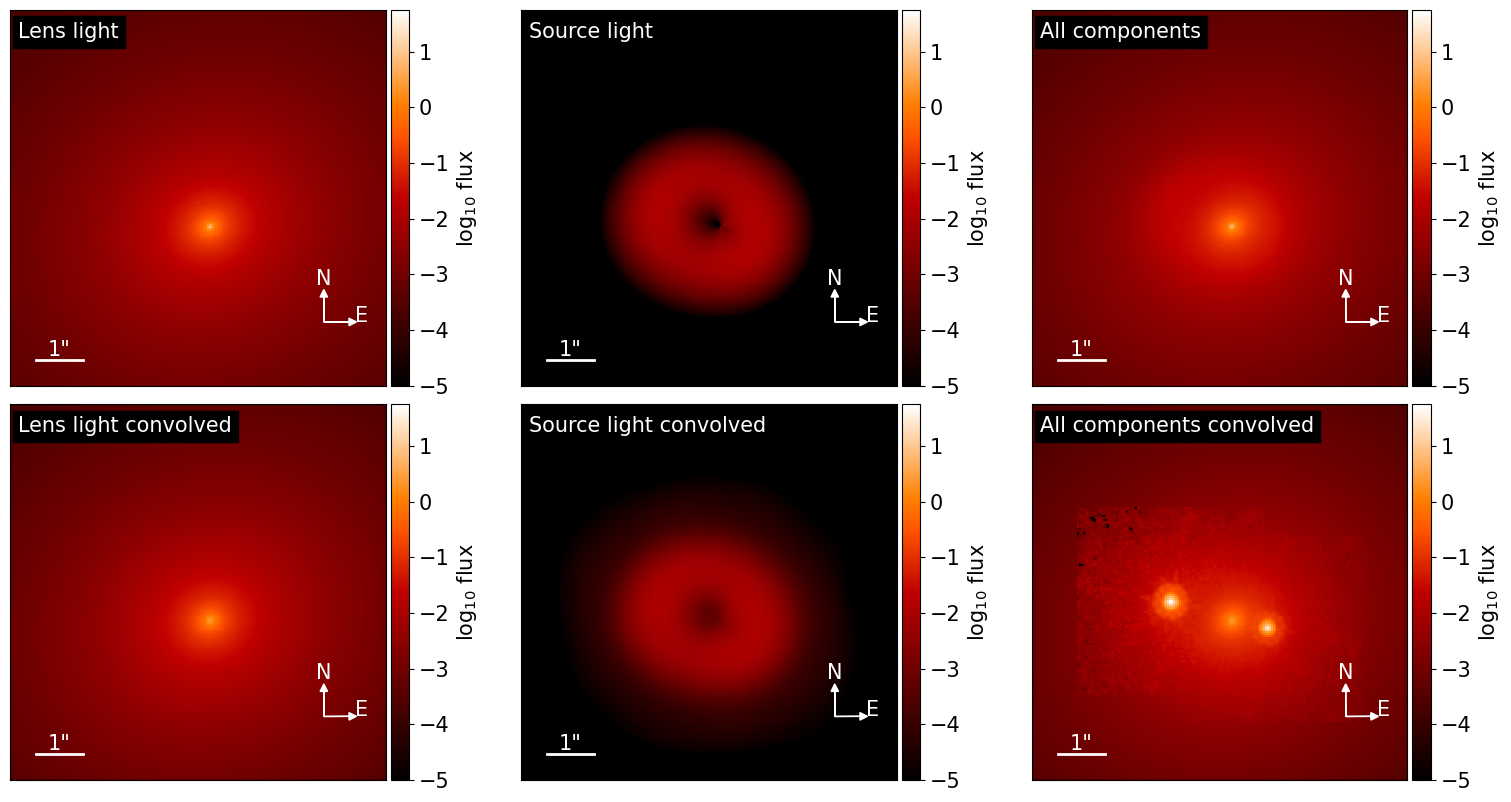

########################################################


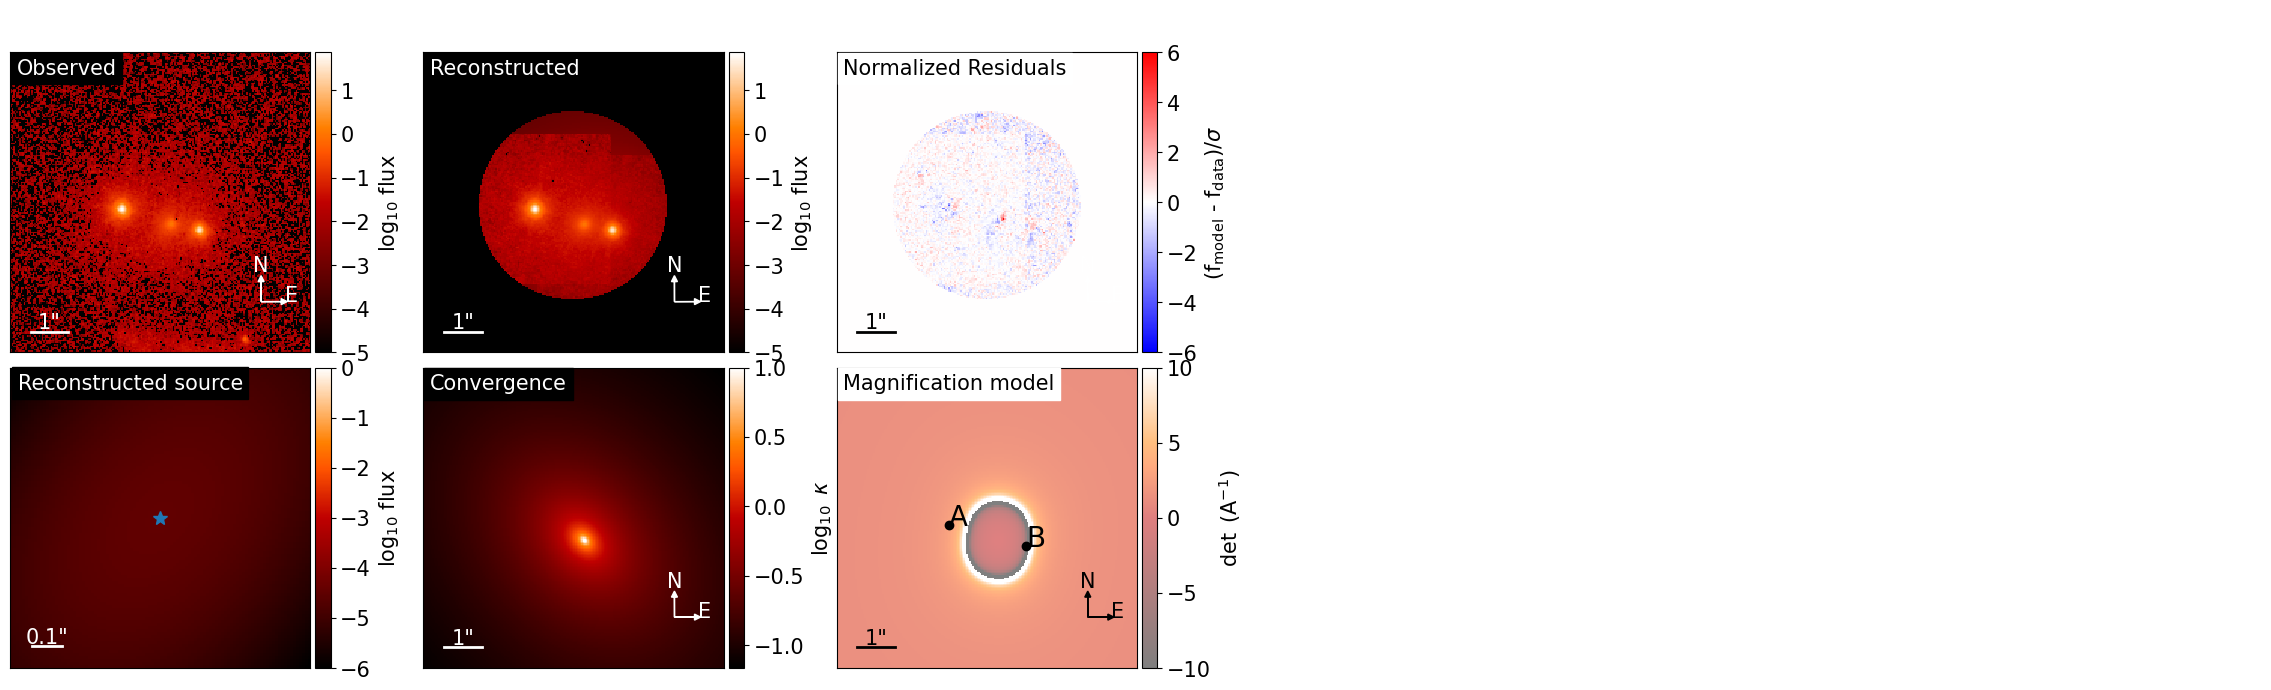

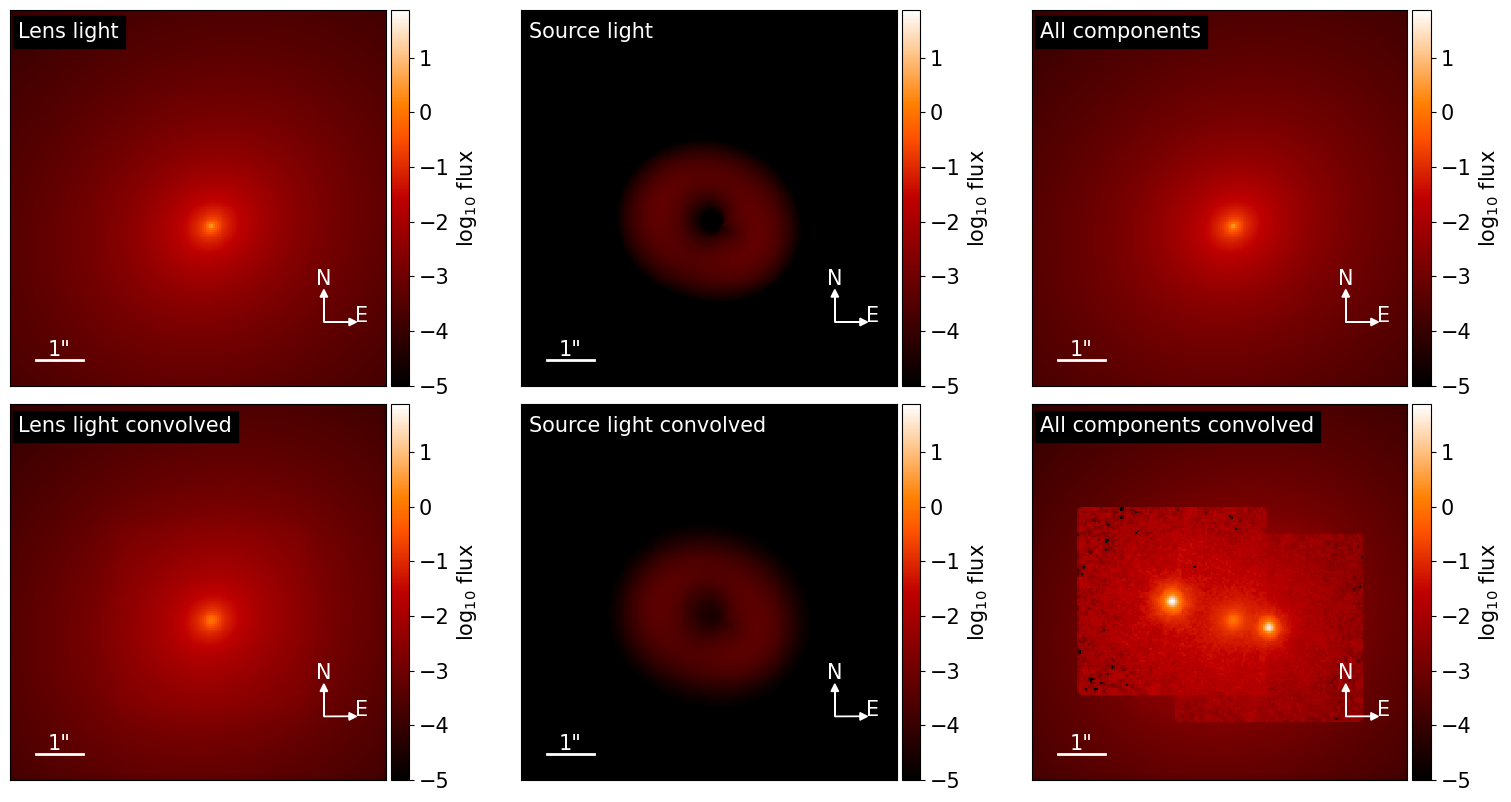

In [28]:
# run a final round of optimization + posterior sampling

fitting_kwargs_list = [
                       ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 500}],
                       ['psf_iteration', kwargs_psf_iter],
                       ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 500}],
                       ['MCMC', {'n_burn': 500, 'n_run': 1000, 'walkerRatio': 10,'sigma_scale': .1}]
]

with suppress_stdout_stderr(f"joint_modeling/{system_name}/{system_name}_joint_mcmc_chain.txt"):

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

kwargs_result = fitting_seq.best_fit()
multi_band_list_out = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")
    
plot_band(modelPlot, band_index_plot=0)
print('########################################################')
plot_band(modelPlot, band_index_plot=1)
print('########################################################')
plot_band(modelPlot, band_index_plot=2)

In [29]:
# save the class data for later analysis
import pickle

save_dict = {
    "fitting_seq": fitting_seq,
    "kwargs_result": kwargs_result,
    "multi_band_list": multi_band_list,
    "kwargs_model": kwargs_model,
    "kwargs_params": kwargs_params,
    "chain_list": chain_list,
    "kwargs_constraints": kwargs_constraints,
    "kwargs_likelihood": kwargs_likelihood,
    "kwargs_data_joint": kwargs_data_joint
}

with open(f"joint_modeling/{system_name}/{system_name}_joint.pkl", "wb") as f:
    pickle.dump(save_dict, f)
